# Проект: Обучение с учителем: качество модели

## Введение

Интернет-магазин «В один клик» наблюдает снижение покупательской активности среди постоянных клиентов. Поскольку привлечение новых покупателей становится менее эффективным, компания решила сосредоточиться на удержании существующих клиентов с помощью персонализированных предложений.

## Цель исследования

Целью данного исследования является построение модели машинного обучения, способной прогнозировать вероятность снижения покупательской активности клиентов интернет-магазина "В один клик" в ближайшие три месяца. Это позволит сегментировать клиентов и предложить персонализированные стратегии взаимодействия, направленные на повышение их лояльности и покупательской активности.

## Описание данных

Для исследования предоставлены данные в виде четырёх таблиц, содержащие информацию о поведении покупателей, их активности на сайте и финансовых показателях:

1. `market_file.csv` — Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

   Описание данных:
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. `market_money.csv` — Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

   Описание данных:
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

3. `market_time.csv` — Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

   Описание данных:
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

4. `money.csv` — Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

   Описание данных:
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

## План исследования

* Загрузка данных – импорт таблиц, проверка их соответствия описанию.
* Предобработка данных – обработка пропусков и дубликатов, преобразование типов, очистка данных.
* Исследовательский анализ – отбор активных клиентов, анализ признаков, выявление выбросов и аномалий.
* Объединение таблиц – создание единого набора данных.
* Корреляционный анализ – выявление мультиколлинеарности, исключение сильно коррелированных признаков.
* Использование пайплайнов – Обучение моделей KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC, подбор гиперпараметров и выбор лучшей модели.
* Анализ важности признаков – оценка значимости факторов с помощью SHAP.
* Сегментация покупателей – выделение групп покупателей, выбор целевой группы, разработка стратегии персонализированных предложений.
* Общий вывод – подведение итогов исследования, выбор лучшей модели, рекомендации по удержанию клиентов.

## 1. Загрузка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# установим и импортируем необходимую библотеку
!pip install shap -q
import shap

# отключим все предупреждения о будущем удалении устаревших опций
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**1.1 Откроем файлы с данными**

In [2]:
try:
    market_file_df = pd.read_csv('market_file.csv')
except:
    market_file_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

In [3]:
try:
    market_money_df = pd.read_csv('market_money.csv')
except:
    market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

In [4]:
try:
    market_time_df = pd.read_csv('market_time.csv')
except:
    market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

In [5]:
# в файле money.csv запятая используется в разделители цифр, даныые делятся точкой с запятой
try:
    money_df = pd.read_csv('money.csv', sep = ';', decimal = ',')
except:
    money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')

**1.2 Изучим общую информацию о датафреймах**

Выведем первые строки и общую информацию таблицы **market_file_df** с данными о поведении покупателей на сайте.

In [6]:
market_file_df.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [7]:
market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Таблица с данными о поведении покупателей на сайте состоит из 1300 строк и 13 столбцов. Пропусков нет. Типы данных соответствуют данным. В названиях столбцов используется разная стилистика.

Выведем первые строки и общую информацию таблицы **market_money_df** с данными о выручке от покупателей.

In [8]:
market_money_df.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [9]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Таблица с данными о выручке от покупателей состоит из 3900 строк и 3 столбцов. Пропусков нет. Типы данных соответствуют данным. Строк ровно в 3 раза больше чем в первой таблице, потому что на каждого клиента приходится 3 строки с данными разных периодов.

Выведем первые строки и общую информацию таблицы **market_time_df** с данными о времени покупателей на сайте.

In [10]:
market_time_df.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [11]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Таблица с данными с данными о времени покупателей на сайте состоит из 2600 строк и 3 столбцов. Пропусков нет. Типы данных соответствуют данным. Для каждого клиента представленно два периода. Значение "предыдцщий_месяц" написано с ошибкой.

Выведем первые строки и общую информацию таблицы **money_df** с данными о среднемесячной прибыли от покупателей.

In [12]:
money_df.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [13]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Таблица с данными о среднемесячной прибыли от покупателей состоит из 1300 строк и 2 столбцов. Пропусков нет. Типы данных соответствуют данным. В описании данных не указана единица измерения прибыли. Судя по таблице с данными о выручке, единица измерения прибыли - тысячи рублей. Необходимо перевести единмцу измерения прибыли в рубли.

**Промежуточный итог:**

Были загружены 4 таблицы с данными о поведении покупателей на сайте, выручке от покупателей, времени покупателей на сайте и среднемесячной прибыли от покупателей. Была изучена общая информация о предоставленных данных. В таблицах присутствуют столбцы, требующие приведения к единому стилю. Типы данных соответствуют данным. Пропусков в таблицах нет.

## 2. Предобработка данных

**2.1 Предобработка таблицы с данными о поведении покупателей на сайте**

Приведем названия столбцов к единому стилю.

In [14]:
market_file_df = market_file_df.rename(columns={
    "Покупательская активность": "Покупательская_активность",
    "Тип сервиса": "Тип_сервиса",
    "Разрешить сообщать": "Разрешить_сообщать"
})

Поищем дубликаты среди пользователей.

In [15]:
market_file_df['id'].duplicated().sum()

0

Дубликатов пользователей нет.

Разделим признаки на категориальные и количественные:

In [16]:
market_file_cat_features = ['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']
market_file_num_features = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 
                            'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
                            'Ошибка_сервиса', 'Страниц_за_визит']

Посмотрим уникальные значения в столбцах с категориальными данными.

In [17]:
for feature in market_file_cat_features:
    print(f'Уникальные значения в столбце "{feature}":\n{market_file_df[feature].unique()}\n')

Уникальные значения в столбце "Покупательская_активность":
['Снизилась' 'Прежний уровень']

Уникальные значения в столбце "Тип_сервиса":
['премиум' 'стандартт' 'стандарт']

Уникальные значения в столбце "Разрешить_сообщать":
['да' 'нет']

Уникальные значения в столбце "Популярная_категория":
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']



В столбце "Тип_сервиса" имеется опечатка. Заменим значения "стандартт" на "стандарт"

In [18]:
market_file_df['Тип_сервиса'] = market_file_df['Тип_сервиса'].replace({'стандартт': 'стандарт'})

In [19]:
market_file_df['Тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Посмотрим на результат:

In [20]:
market_file_df.head()

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

**2.2 Предобработка таблицы с данными о выручке от покупателей**

Поищем дубликаты

In [21]:
market_money_df[['id', 'Период']].duplicated().sum()

0

Дубликатов нет.

Посмотрим уникальные значения в столбце 'Период'.

In [22]:
market_money_df['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Данные не требуют предобработки.

In [23]:
market_money_df.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

**2.3 Предобработка таблицы с данными о времени покупателей на сайте**

Приведем название столбца 'минут' к единому стилю.

In [24]:
market_time_df = market_time_df.rename(columns={"минут": "Минут"})

Поищем дубликаты

In [25]:
market_time_df[['id', 'Период']].duplicated().sum()

0

Дубликатов нет.

Заменим значения "предыдцщий_месяц" на "предыдущий_месяц"

In [26]:
market_time_df['Период'] = market_time_df['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

Посмотрим уникальные значения в столбце 'Период'.

In [27]:
market_time_df['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Посмотрим на результат:

In [28]:
market_time_df.head()

id            Период  Минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

**2.4 Предобработка таблицы с данными о среднемесячной прибыли от покупателей**

Домножим значения столбца Прибыль на 1000, чтобы привести к общей единице измерения - рублям.

In [29]:
money_df['Прибыль'] = money_df['Прибыль'] * 1000

Поищем дубликаты

In [30]:
money_df.duplicated().sum()

0

Дубликатов нет. Отсутствие пропусков и соответствие типов данным было установлено в ходе просмотра общей информации о датафрейме.

In [31]:
money_df.head()

id  Прибыль
0  215348    980.0
1  215349   4160.0
2  215350   3130.0
3  215351   4870.0
4  215352   4210.0

**Промежуточный итог:**

В ходе предобработки данных таблицы были подготовлены к дальнейшему анализу. Данные исследованы на наличие дубликатов - дубликатов нет. Пропусков нет. Типы данных соответствуют данным. Названия столбцов приведены к единому стилю. Исправлены опечатки.

## 3. Исследовательский анализ данных

**3.1 Исследовательский анализ таблицы с данными о поведении покупателей на сайте**

In [32]:
market_file_df.head()

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Посмотрим статистическое описание данных.

In [33]:
market_file_df.describe(include='all')

id Покупательская_активность Тип_сервиса  \
count     1300.000000                      1300        1300   
unique            NaN                         2           2   
top               NaN           Прежний уровень    стандарт   
freq              NaN                       802         924   
mean    215997.500000                       NaN         NaN   
std        375.421985                       NaN         NaN   
min     215348.000000                       NaN         NaN   
25%     215672.750000                       NaN         NaN   
50%     215997.500000                       NaN         NaN   
75%     216322.250000                       NaN         NaN   
max     216647.000000                       NaN         NaN   

       Разрешить_сообщать  Маркет_актив_6_мес  Маркет_актив_тек_мес  \
count                1300         1300.000000           1300.000000   
unique                  2                 NaN                   NaN   
top                    да                 NaN                   NaN   
freq                  962                 NaN                   NaN   
mean                  NaN            4.253769              4.011538   
std                   NaN            1.014814              0.696868   
min                   NaN            0.900000              3.000000   
25%                   NaN            3.700000              4.000000   
50%                   NaN            4.200000              4.000000   
75%                   NaN            4.900000              4.000000   
max                   NaN            6.600000              5.000000   

        Длительность  Акционные_покупки Популярная_категория  \
count    1300.000000        1300.000000                 1300   
unique           NaN                NaN                    6   
top              NaN                NaN     Товары для детей   
freq             NaN                NaN                  330   
mean      601.898462           0.319808                  NaN   
std       249.856289           0.249843                  NaN   
min       110.000000           0.000000                  NaN   
25%       405.500000           0.170000                  NaN   
50%       606.000000           0.240000                  NaN   
75%       806.000000           0.300000                  NaN   
max      1079.000000           0.990000                  NaN   

        Средний_просмотр_категорий_за_визит  \
count                            1300.00000   
unique                                  NaN   
top                                     NaN   
freq                                    NaN   
mean                                3.27000   
std                                 1.35535   
min                                 1.00000   
25%                                 2.00000   
50%                                 3.00000   
75%                                 4.00000   
max                                 6.00000   

        Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
count                          1300.000000     1300.000000       1300.000000  
unique                                 NaN             NaN               NaN  
top                                    NaN             NaN               NaN  
freq                                   NaN             NaN               NaN  
mean                              2.840000        4.185385          8.176923  
std                               1.971451        1.955298          3.978126  
min                               0.000000        0.000000          1.000000  
25%                               1.000000        3.000000          5.000000  
50%                               3.000000        4.000000          8.000000  
75%                               4.000000        6.000000         11.000000  
max                              10.000000        9.000000         20.000000

Аномалий и вбросов не наблюдается.

Напишем функцию для визуализации распределения и разброса данных.

In [34]:
def show_plots(df, feature, type='hist', new_bins=0, new_hue=None):
    """
    Выводит в общем окне два графика для визуализации распределения и разброса данных.

    Параметры:
    df (pd.DataFrame): DataFrame с данными.
    feature (str): Название признака для визуализации.
    type (str, optional): 'hist' - Выводит гистограмму и горизонтальную диаграмму размаха.
                                   Используется по умолчанию.
                          'bars' - Выводит cтолбчатую диаграмму частот и горизонтальную диаграмму размаха.
    new_bins (int, optional): Количество корзин для гистограммы. 
                              Если 0, используется значение по умолчанию
                              и происходит автоматический подбор количества корзин.
    new_hue (str, optional): Название признака для категоризации.
                             По умолчанию - None
    """
    
    # Задаем количесво знаков после запятой в зависимости
    if abs(df[feature].max()) > 1000:
        rnd = 0
    elif abs(df[feature].max()) > 100:
        rnd = 1
    elif abs(df[feature].max()) > 10:
        rnd = 2
    elif abs(df[feature].max()) > 1:
        rnd = 3
    else:
        rnd = 4
    
    plt.figure(figsize=(12, 5))

    if type=='hist':
        # Гистограмма
        plt.subplot(1, 2, 1)
        if new_bins == 0:
            sns.histplot(x=feature, data=df.dropna(subset=[feature]), kde=True, color='#a1c9f4', hue=new_hue)
        else:
            sns.histplot(x=feature, data=df.dropna(subset=[feature]), kde=True, color='#a1c9f4', hue=new_hue, bins=new_bins)
        plt.title(f'Гистограмма для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    elif type=='bars':
        # Столбчатая диаграмма частот
        plt.subplot(1, 2, 1)
        sns.countplot(x=feature, data=df.dropna(subset=[feature]), edgecolor="black", color='#a1c9f4', hue=new_hue)
        plt.title(f'Диаграмма частот для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    else:
        plt.subplot(1, 2, 1)
        plt.title('Неправильно задан параметр type')

    # Горизонтальная диаграмма размаха (Boxplot)
    plt.subplot(1, 2, 2)
    bp = sns.boxplot(x=df[feature].dropna(), 
                     orient='h', 
                     color='#b5d9ff', 
                     width=0.2)
    bp.set_title(f'Диаграмма размаха для {feature}')
    bp.set_xlabel(feature)

    data = df[feature].dropna()

    # Извлечение статистики
    quartiles = np.percentile(data, [25, 50, 75])  # Q1, медиана, Q3
    q1, median, q3 = quartiles
    iqr = q3 - q1
    lower_whisker = max(min(data), q1 - 1.5 * iqr)
    upper_whisker = min(max(data), q3 + 1.5 * iqr)
    outliers = [x for x in data if x < lower_whisker or x > upper_whisker]

    # Подписываем значения через annotate с поворотом текста
    for value, label in zip([q1, median, q3, lower_whisker, upper_whisker],
                            ['Q1', 'Медиана', 'Q3', 'Мин', 'Макс']):
        bp.annotate(f"{label}: {value:.{rnd}f}",
                    xy=(value, 0),
                    xytext=(value, 0.45),
                    textcoords='data',
                    ha='center',
                    fontsize=9,
                    rotation=90)

    # Отметка выбросов
    for outlier in outliers:
        bp.annotate(f"Выброс: {outlier:.{rnd}f}",
                    xy=(outlier, 0),
                    xytext=(outlier, -0.15),
                    textcoords='data',
                    ha='center',
                    fontsize=9,
                    color='red',
                    rotation=90)

    # Добавление среднего значения
    mean_value = data.mean()
    bp.annotate(f"Среднее: {mean_value:.{rnd}f}",
                xy=(mean_value, 0),
                xytext=(mean_value, -0.15),
                textcoords='data',
                ha='center',
                fontsize=9,
                color='blue',
                rotation=90)

    # Добавление количества выбросов
    bp.annotate(f'Количество выбросов: {len(outliers)}',
                xy=(data.min(), -0.45),
                xytext=(data.min(), -0.45),
                textcoords='data',
                ha='left',
                fontsize=10,
                color='purple')

# Настройка цветов линий коробки через Matplotlib
    for line in bp.artists:
        line.set_edgecolor('blue')  # Цвет линий коробки
    
    # Показ графика
    plt.tight_layout()
    plt.show()

In [35]:
print(show_plots.__doc__)


    Выводит в общем окне два графика для визуализации распределения и разброса данных.

    Параметры:
    df (pd.DataFrame): DataFrame с данными.
    feature (str): Название признака для визуализации.
    type (str, optional): 'hist' - Выводит гистограмму и горизонтальную диаграмму размаха.
                                   Используется по умолчанию.
                          'bars' - Выводит cтолбчатую диаграмму частот и горизонтальную диаграмму размаха.
    new_bins (int, optional): Количество корзин для гистограммы. 
                              Если 0, используется значение по умолчанию
                              и происходит автоматический подбор количества корзин.
    new_hue (str, optional): Название признака для категоризации.
                             По умолчанию - None
    


In [36]:
help(show_plots)

Help on function show_plots in module __main__:

show_plots(df, feature, type='hist', new_bins=0, new_hue=None)
    Выводит в общем окне два графика для визуализации распределения и разброса данных.
    
    Параметры:
    df (pd.DataFrame): DataFrame с данными.
    feature (str): Название признака для визуализации.
    type (str, optional): 'hist' - Выводит гистограмму и горизонтальную диаграмму размаха.
                                   Используется по умолчанию.
                          'bars' - Выводит cтолбчатую диаграмму частот и горизонтальную диаграмму размаха.
    new_bins (int, optional): Количество корзин для гистограммы. 
                              Если 0, используется значение по умолчанию
                              и происходит автоматический подбор количества корзин.
    new_hue (str, optional): Название признака для категоризации.
                             По умолчанию - None



Построим гистограммы и диаграммы размаха для всех количественных признаков.

In [37]:
#for feature in market_file_num_features:
#    show_hist_and_scatterplot(market_file_df, feature)

Визуализируем распределение данных.

Для количественных признаков с непрерывными данными построим гистограммы и диаграммы размаха. 

Для количественных признаков с дискретными данными будем выводить столбчатые диаграммы частот и диаграммы размаха.

In [38]:
market_file_num_features_discrete = ['Маркет_актив_тек_мес', 'Средний_просмотр_категорий_за_визит', 
                                     'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']

In [39]:
market_file_num_features_continuous = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки']

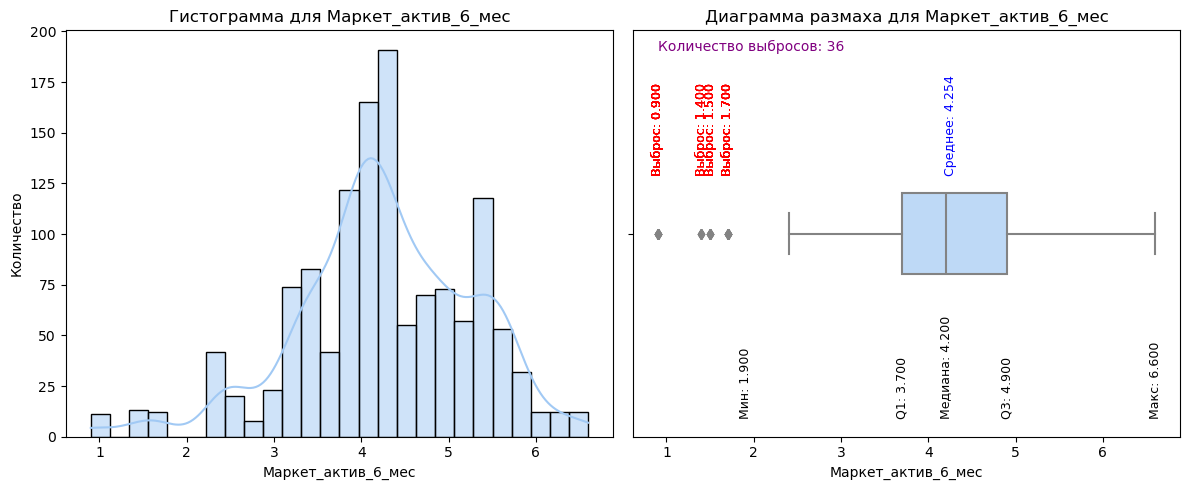

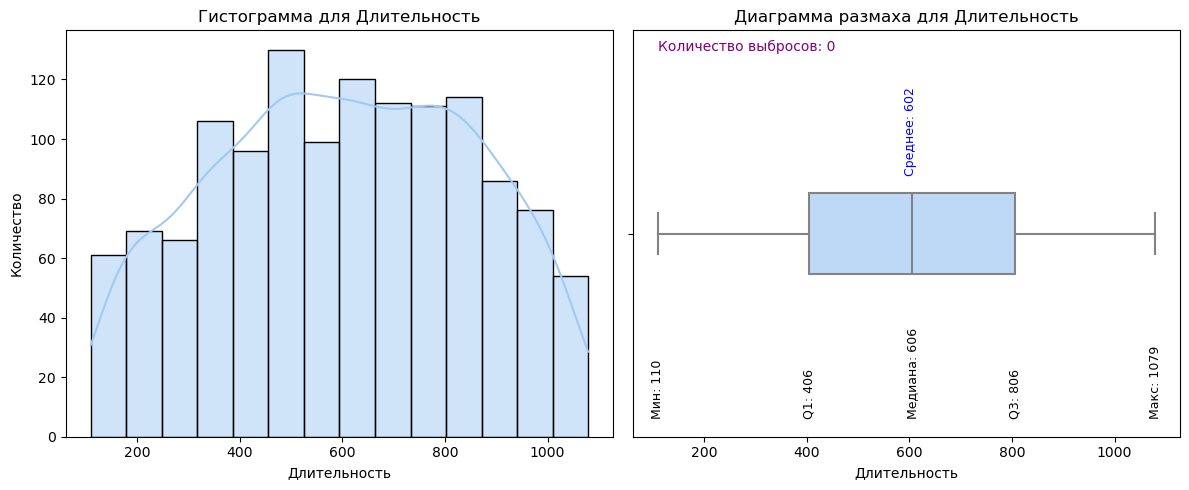

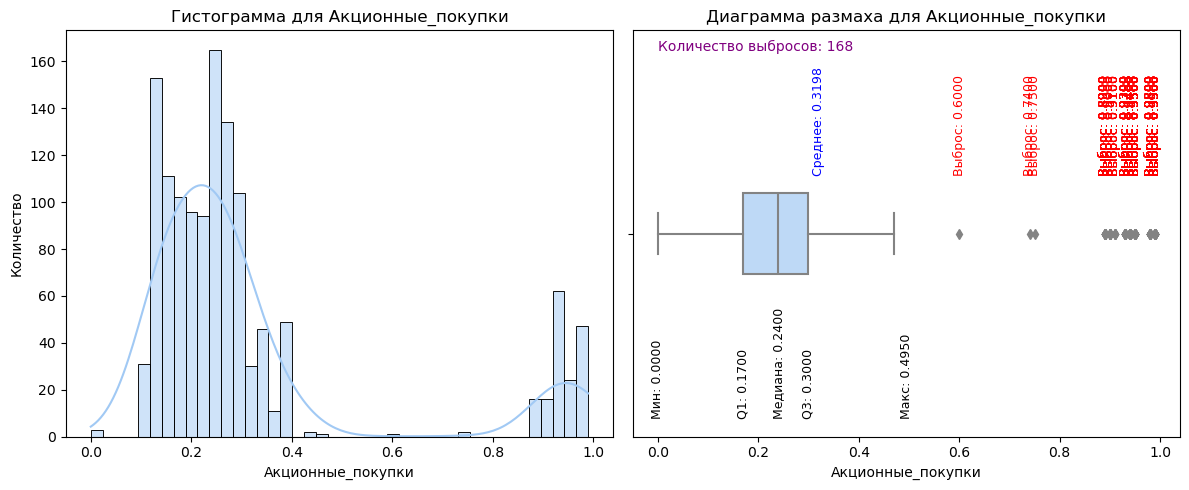

In [40]:
for feature in market_file_num_features_continuous:
    show_plots(market_file_df, feature)

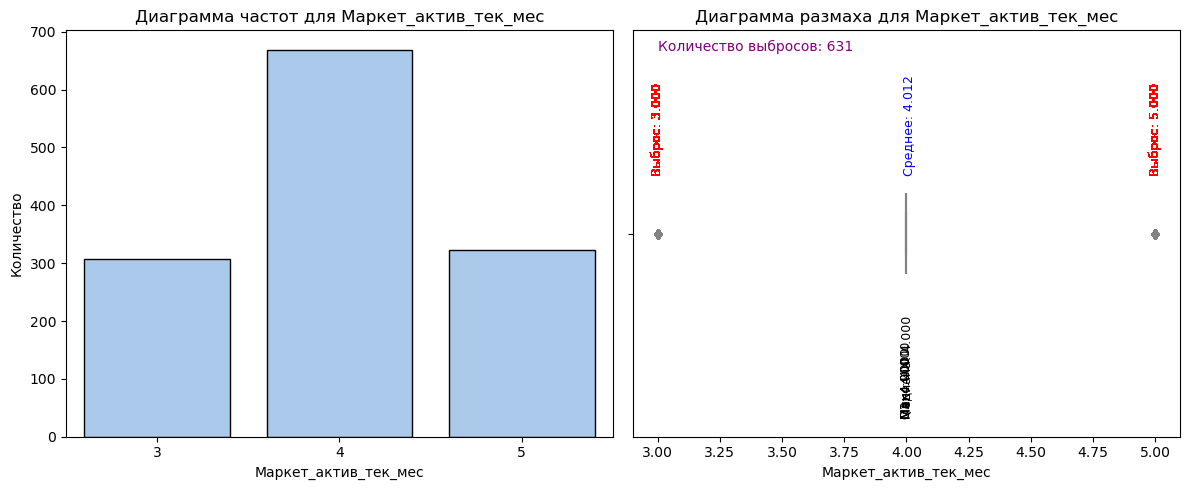

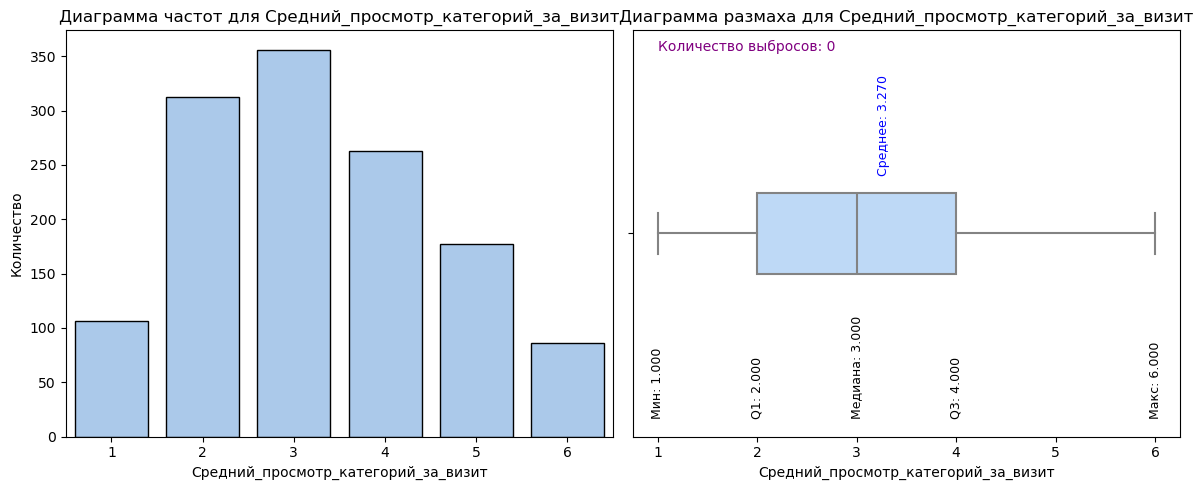

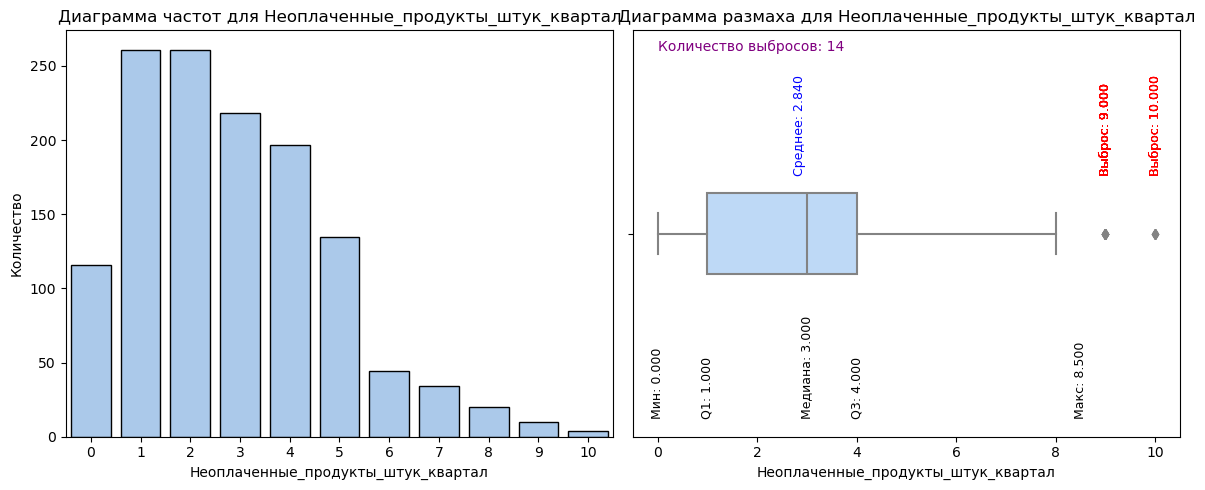

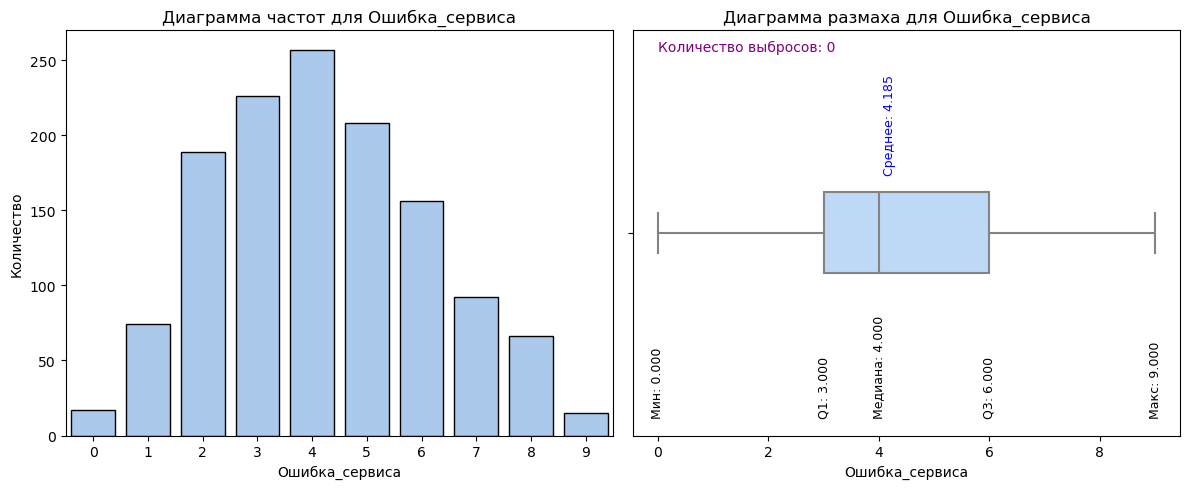

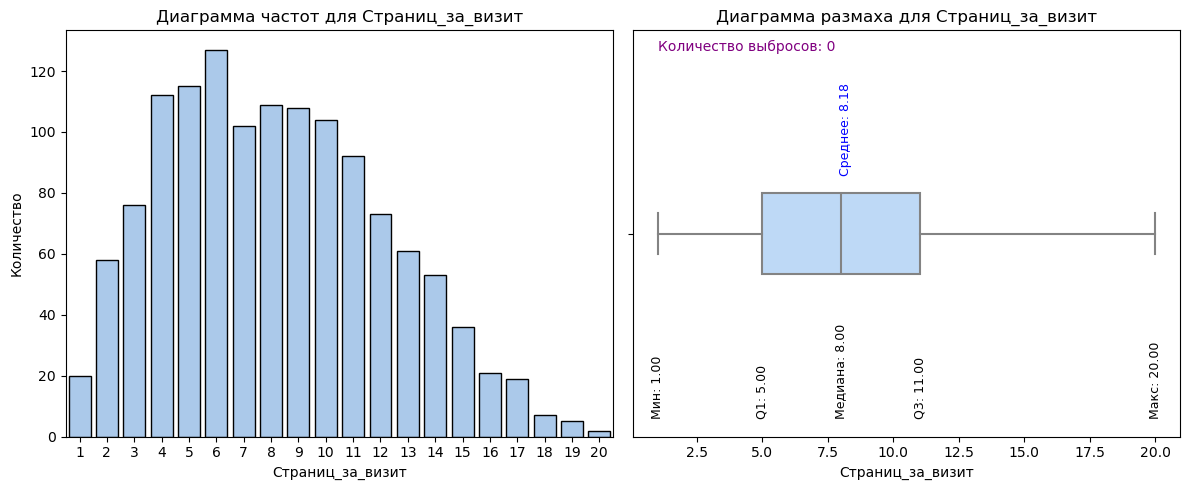

In [41]:
for feature in market_file_num_features_discrete:
    show_plots(market_file_df, feature, 'bars')

Распределение среднего числа маркетинговых коммуникаций можно считаль условно нормальным со средним значением 4,2 коммуникации в месяц. Межквартильный размах от 3,7 до 4,9 маркетинговых коммуникаций в месяц в среднем. Число маркетинговых коммуникаций менее 2 можно считать аномально низким.

В текущем месяце более половины покупателей получило по 4 маркетинговых предложения. Остальные клиенты получили по 3 или 5 маркетинговых предложений.

Гистограмма дней с момента регистрации покупателя на сайте показывает снижение привлечения новых клиентов в последние 450 дней.

Распределение среднемесячной доли покупок по акции показывает что среднее медианное значение доли покупок по акции 24%. Межквартильный размах от 17% до 30%. При этом примерно 10% клиентов совершают около 90% покупок по акции.

Распределение среднего количества просмотра категорий за визит имеет вид распределения Пуассона. Среднее медианное значение 3 категории за визит. Межквартильный размах от 2 до 4. Выбросов нет.

Неоплаченных товаров в корзине имеет вид распределения Пуассона со средним медианным значением 3 и межквартильным размахом от 1 до 4. Количество неоплаченных товаров в корзине более 8 можно считать аномально большим.

Количество ошибок сервиса, которые коснулись покупателя во время посещения сайта, имеет распределение Пуассона со средним медианным значением 4 и межквартильным размахом от 3 до 6. Выбросов нет.

Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца имеет вид распределения Пуассона. Среднее медианное значение 8 страниц. Межквартильный размах от 2 до 4. Выбросов нет.

Для категориальных данных построим круговые диаграммы.

Напишем функцию для вывода круговых диаграмм.

In [42]:
def show_pie(df, features):

    lines = math.ceil(len(features)/2)
    
    plt.figure(figsize=(12, 5*lines))
    count = 1
    for feature in features:
        plt.subplot(lines, 2, count)
        count += 1
        df[feature].value_counts().plot(
        kind='pie',
        autopct='%1.1f%%',
        colors = sns.color_palette('pastel')
    )
        plt.title(f'Круговая диаграмма для {feature}')
        plt.ylabel(None)
    
    # Показ графика
    plt.tight_layout()
    plt.show()

Выведем круговые диаграммы для всех категориальных признаков.

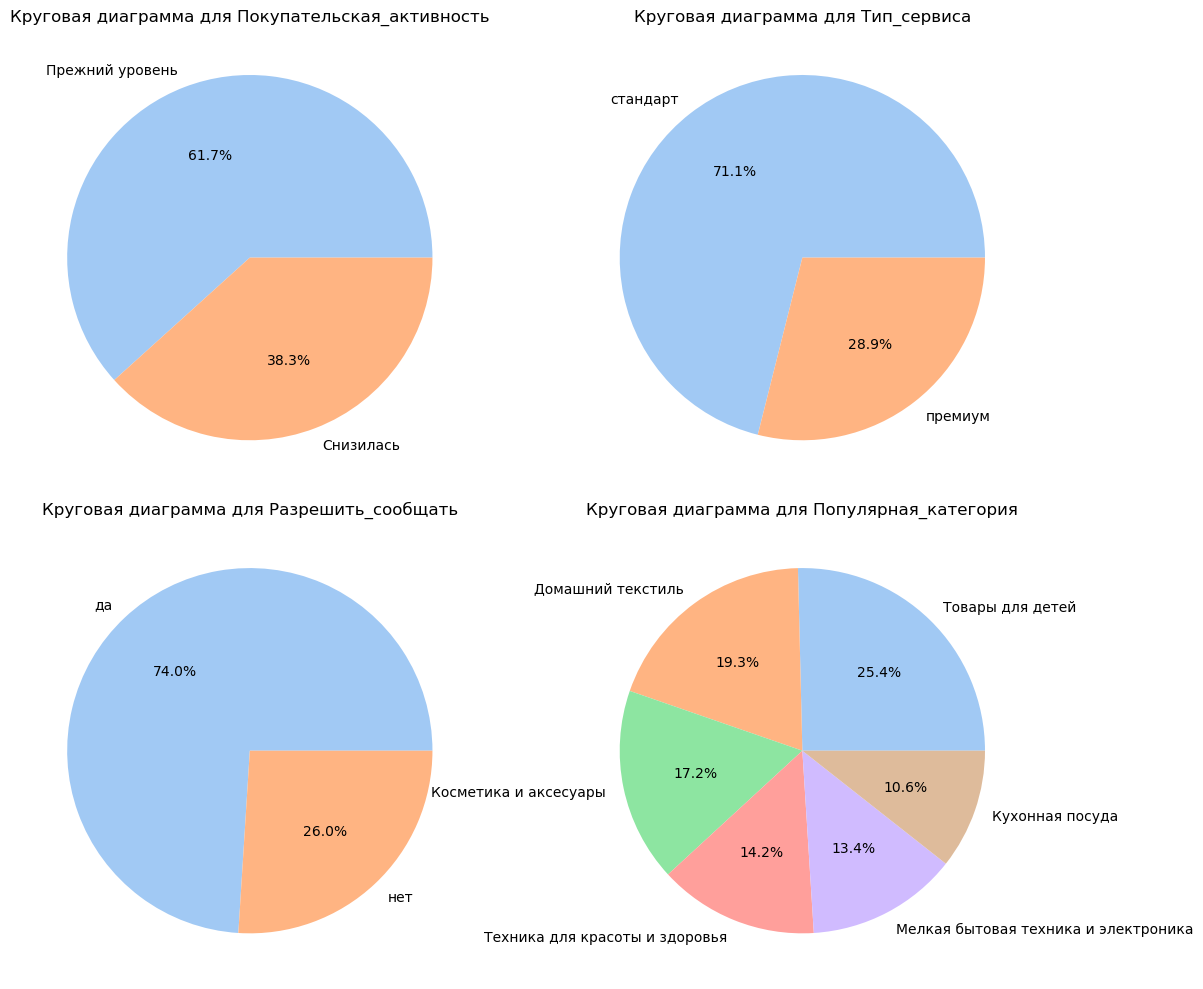

In [43]:
show_pie(market_file_df, market_file_cat_features)

Покупательская активность 38,3% клиентов снизилась. Небольшой дисбаланс между двумя категориями целевого признака не должен повлиять на качество моделей.

28,9% клиентов имеет Премиум подписку, остальные клиенты используют стандартный уровень сервиса.

26% клиентов не дают согласие на получение дополнительных предложений о товаре.

Популярные категории распределяются достаточно равномерно с наименьшим значением у Кухоной посуды (10,6%) и наибольшим значением у Товаров для детей (25,4%).

**3.2 Исследовательский анализ таблицы с данными о выручке от покупателей**

In [44]:
market_money_df.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

Посмотрим статистическое описание данных.

In [45]:
market_money_df.describe(include='all')

id               Период        Выручка
count     3900.000000                 3900    3900.000000
unique            NaN                    3            NaN
top               NaN  препредыдущий_месяц            NaN
freq              NaN                 1300            NaN
mean    215997.500000                  NaN    5025.696051
std        375.325686                  NaN    1777.704104
min     215348.000000                  NaN       0.000000
25%     215672.750000                  NaN    4590.150000
50%     215997.500000                  NaN    4957.500000
75%     216322.250000                  NaN    5363.000000
max     216647.000000                  NaN  106862.200000

Посмотрим на максимальные месячные выручки.

In [46]:
market_money_df.sort_values(by='Выручка', ascending=False).head()

id         Период   Выручка
98    215380  текущий_месяц  106862.2
435   215493  текущий_месяц    7799.4
262   215435  текущий_месяц    7605.3
1481  215841  текущий_месяц    7557.0
2388  216144  текущий_месяц    7547.8

Имеется одно аномальное значение, которое выбивается из общего правила и может повлиять на результаты исследований. Заменим значение в строке 98 на средннюю медианную выручку в Текущем месяце.

In [47]:
market_money_df.loc[98, 'Выручка'] = market_money_df['Выручка'].median()

In [48]:
market_money_df.loc[98]

id                215380
Период     текущий_месяц
Выручка           4957.5
Name: 98, dtype: object

Отберем клиентов, которые совершали покупки за последние 3 месяца.

In [49]:
revenue_df = market_money_df.groupby('id')['Выручка'].sum().reset_index()

market_file_df_active = revenue_df[revenue_df['Выручка'] > 0]
market_file_df_active

id  Выручка
0     215348   3293.1
1     215349  14659.6
2     215350  15341.9
3     215351  17561.4
4     215352  16274.0
...      ...      ...
1295  216643  13109.7
1296  216644  15381.0
1297  216645  15633.2
1298  216646  14872.6
1299  216647  14351.3

[1300 rows x 2 columns]

Все 1300 клиентов совершали покупки за последние 3 месяца.

In [50]:
market_money_df[market_money_df['Выручка']==0]

id               Период  Выручка
0   215348  препредыдущий_месяц      0.0
2   215348     предыдущий_месяц      0.0
28  215357  препредыдущий_месяц      0.0
29  215357     предыдущий_месяц      0.0
34  215359     предыдущий_месяц      0.0
35  215359  препредыдущий_месяц      0.0

Действительно все клиенты совершали покупки за последние 3 месяца. Только три клиента не совершали покупок в предыдущий и предпредыдущий месяц.

Построим гистограммы и диаграммы размаха для всех количественных признаков.

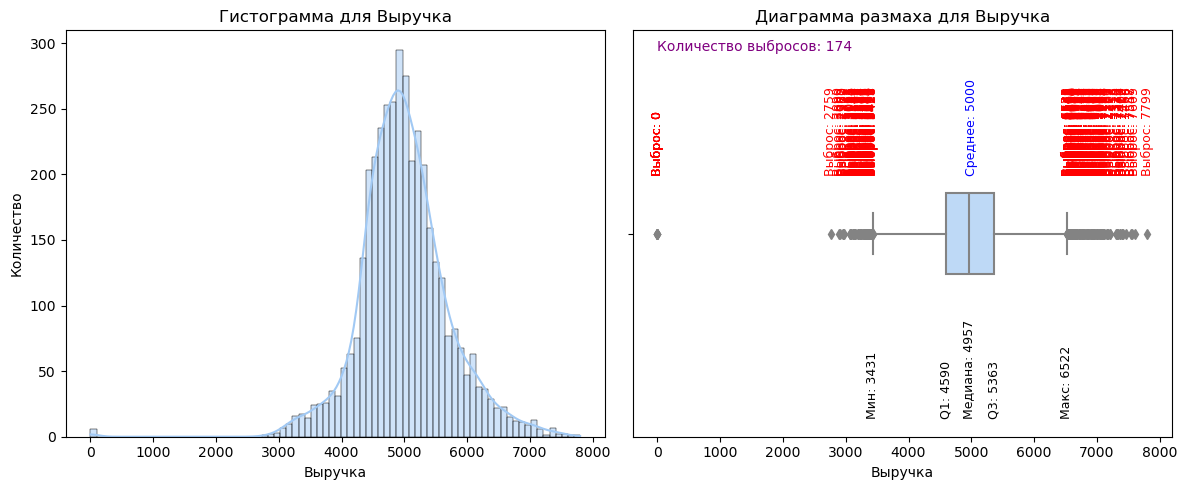

In [51]:
show_plots(market_money_df, 'Выручка')

Месячная выручка с покупателя имеет нормальное распределение.

Среднее значение - 5000 руб.

Медианное значение - 4957 руб.

Межквартильный размах от 4590 до 5363 рублей.

Выручку с покупателя менее 3431 руб за месяц можно считать аномально низкой.

Выручку с покупателя более 6522 руб за месяц можно считать аномально высокой.

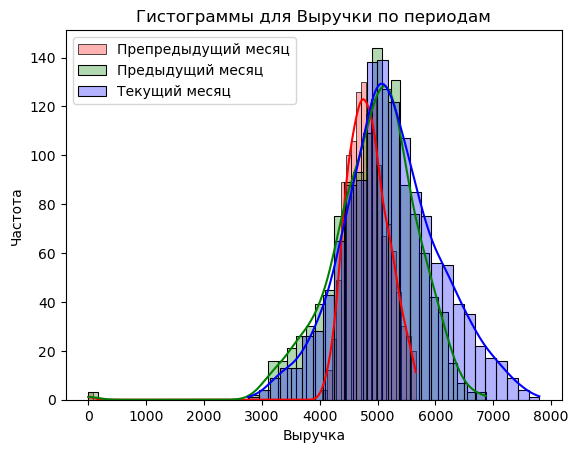

In [52]:
sns.histplot(market_money_df[market_money_df['Период']=='препредыдущий_месяц']['Выручка'].dropna(), 
             kde=True, alpha=0.3, color='red', label='Препредыдущий месяц')
sns.histplot(market_money_df[market_money_df['Период']=='предыдущий_месяц']['Выручка'].dropna(), 
             kde=True, alpha=0.3, color='green', label='Предыдущий месяц')
sns.histplot(market_money_df[market_money_df['Период']=='текущий_месяц']['Выручка'].dropna(), 
             kde=True, alpha=0.3, color='blue', label='Текущий месяц')

plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Гистограммы для Выручки по периодам')
plt.legend()

plt.show()

In [53]:
market_money_df[market_money_df['Период']=='препредыдущий_месяц'].describe(include='all')

id               Период      Выручка
count     1300.000000                 1300  1300.000000
unique            NaN                    1          NaN
top               NaN  препредыдущий_месяц          NaN
freq              NaN                 1300          NaN
mean    215997.500000                  NaN  4825.206923
std        375.421985                  NaN   405.979663
min     215348.000000                  NaN     0.000000
25%     215672.750000                  NaN  4583.000000
50%     215997.500000                  NaN  4809.000000
75%     216322.250000                  NaN  5053.500000
max     216647.000000                  NaN  5663.000000

In [54]:
market_money_df[market_money_df['Период']=='предыдущий_месяц'].describe(include='all')

id            Период      Выручка
count     1300.000000              1300  1300.000000
unique            NaN                 1          NaN
top               NaN  предыдущий_месяц          NaN
freq              NaN              1300          NaN
mean    215997.500000               NaN  4936.920385
std        375.421985               NaN   739.597997
min     215348.000000               NaN     0.000000
25%     215672.750000               NaN  4496.750000
50%     215997.500000               NaN  5005.000000
75%     216322.250000               NaN  5405.625000
max     216647.000000               NaN  6869.500000

In [55]:
market_money_df[market_money_df['Период']=='текущий_месяц'].describe(include='all')

id         Период      Выручка
count     1300.000000           1300  1300.000000
unique            NaN              1          NaN
top               NaN  текущий_месяц          NaN
freq              NaN           1300          NaN
mean    215997.500000            NaN  5236.572615
std        375.421985            NaN   835.188961
min     215348.000000            NaN  2758.700000
25%     215672.750000            NaN  4706.050000
50%     215997.500000            NaN  5179.550000
75%     216322.250000            NaN  5759.275000
max     216647.000000            NaN  7799.400000

Последние 3 месяца средняя выручка увеличивалась. Также увеличилась максимальная выручка и разброс величины выручки от разных клиентов (дисперсия).

**3.3 Исследовательский анализ таблицы с данными о времени покупателей на сайте**

In [56]:
market_time_df.head()

id            Период  Минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

In [57]:
market_time_df.describe(include='all')

id         Период        Минут
count     2600.000000           2600  2600.000000
unique            NaN              2          NaN
top               NaN  текущий_месяц          NaN
freq              NaN           1300          NaN
mean    215997.500000            NaN    13.336154
std        375.349754            NaN     4.080198
min     215348.000000            NaN     4.000000
25%     215672.750000            NaN    10.000000
50%     215997.500000            NaN    13.000000
75%     216322.250000            NaN    16.000000
max     216647.000000            NaN    23.000000

Построим гистограмму и диаграмму размаха.

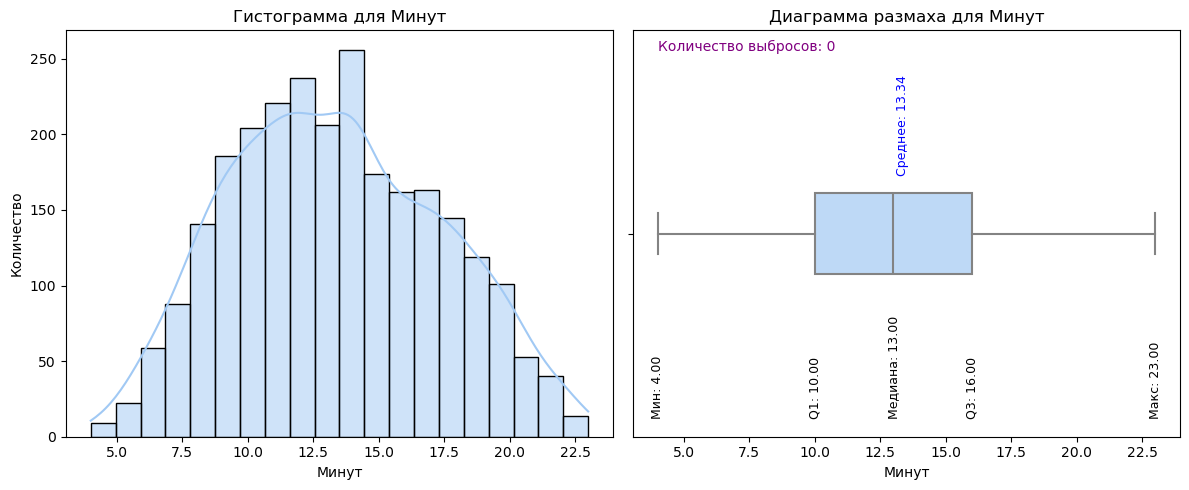

In [58]:
show_plots(market_time_df, 'Минут', new_bins=20)

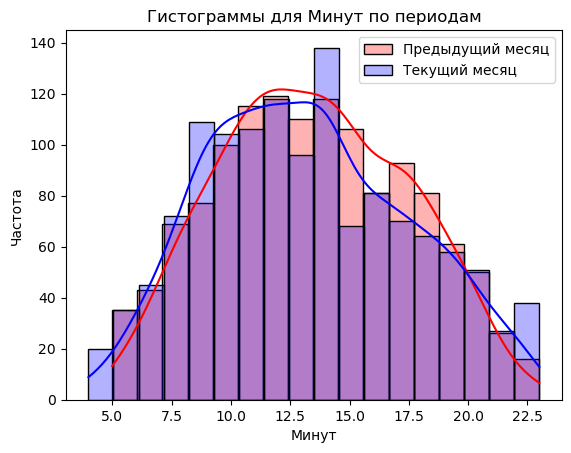

In [59]:
sns.histplot(market_time_df[market_time_df['Период']=='предыдущий_месяц']['Минут'].dropna(), 
             kde=True, alpha=0.3, color='red', label='Предыдущий месяц')
sns.histplot(market_time_df[market_time_df['Период']=='текущий_месяц']['Минут'].dropna(), 
             kde=True, alpha=0.3, color='blue', label='Текущий месяц')

plt.xlabel('Минут')
plt.ylabel('Частота')
plt.title('Гистограммы для Минут по периодам')
plt.legend()

plt.show()

In [60]:
market_time_df[market_time_df['Период']=='предыдущий_месяц'].describe(include='all')

id            Период        Минут
count     1300.000000              1300  1300.000000
unique            NaN                 1          NaN
top               NaN  предыдущий_месяц          NaN
freq              NaN              1300          NaN
mean    215997.500000               NaN    13.467692
std        375.421985               NaN     3.932029
min     215348.000000               NaN     5.000000
25%     215672.750000               NaN    11.000000
50%     215997.500000               NaN    13.000000
75%     216322.250000               NaN    17.000000
max     216647.000000               NaN    23.000000

In [61]:
market_time_df[market_time_df['Период']=='текущий_месяц'].describe(include='all')

id         Период        Минут
count     1300.000000           1300  1300.000000
unique            NaN              1          NaN
top               NaN  текущий_месяц          NaN
freq              NaN           1300          NaN
mean    215997.500000            NaN    13.204615
std        375.421985            NaN     4.220589
min     215348.000000            NaN     4.000000
25%     215672.750000            NaN    10.000000
50%     215997.500000            NaN    13.000000
75%     216322.250000            NaN    16.000000
max     216647.000000            NaN    23.000000

Среднее время на сайте - 13,34 минуты за месяц.

Медианное значение - 13 минут.

Межквартильный размах от 10 до 16 минут.

Время на сайте менее 4 минут за месяц можно считать аномально низким.

Время на сайте более 23 минут за месяц можно считать аномально высоким.

Разница в статистических показателях между предыдущим месяцем и текущим незначительна, чтобы делать выводы о какой-либо тенденции.

**3.4 Исследовательский анализ таблицы с данными о среднемесячной прибыли от покупателей**

In [62]:
money_df.head()

id  Прибыль
0  215348    980.0
1  215349   4160.0
2  215350   3130.0
3  215351   4870.0
4  215352   4210.0

In [63]:
money_df.describe(include='all')

id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000  3996.630769
std       375.421985  1013.722112
min    215348.000000   860.000000
25%    215672.750000  3300.000000
50%    215997.500000  4045.000000
75%    216322.250000  4670.000000
max    216647.000000  7430.000000

Построим гистограмму и диаграмму размаха.

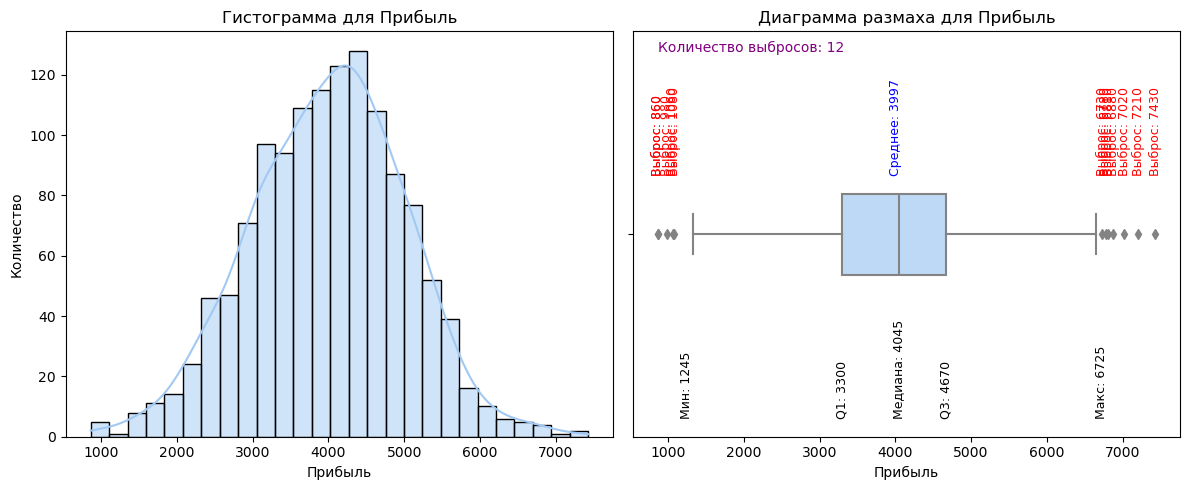

In [64]:
show_plots(money_df, 'Прибыль')

Среднемесячная прибыль с покупателя за роследние 3 месяца имеет нормальное распределение.

Среднее значение - 3996,63 руб.

Медианное значение - 4045 руб.

Межквартильный размах от 3300 до 4670 рублей.

Прибыль с покупателя менее 1245 руб за месяц можно считать аномально низкой.

Прибыль с покупателя более 6725 руб за месяц можно считать аномально высокой.

**Промежуточный итог:**

В ходе проведения исследовательского анализа таблиц была изучена и описана статистика данных по всем отдельным столбцам датафреймов.

Информация была визуализирована.

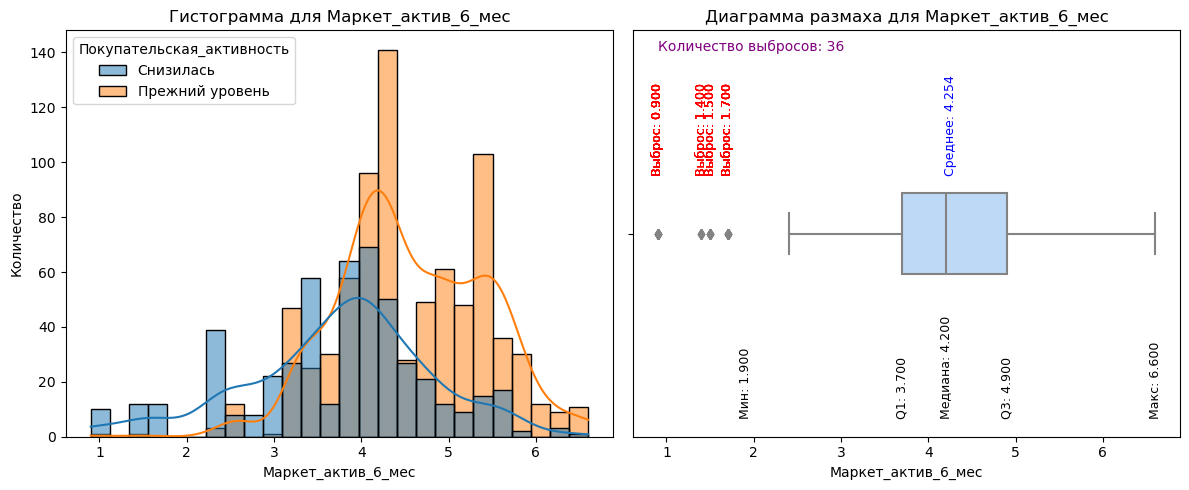

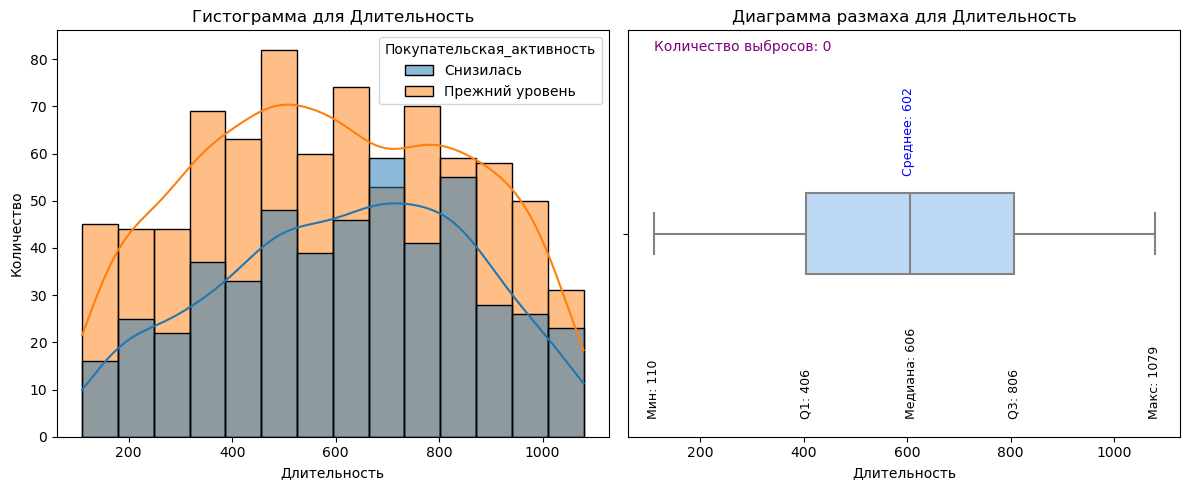

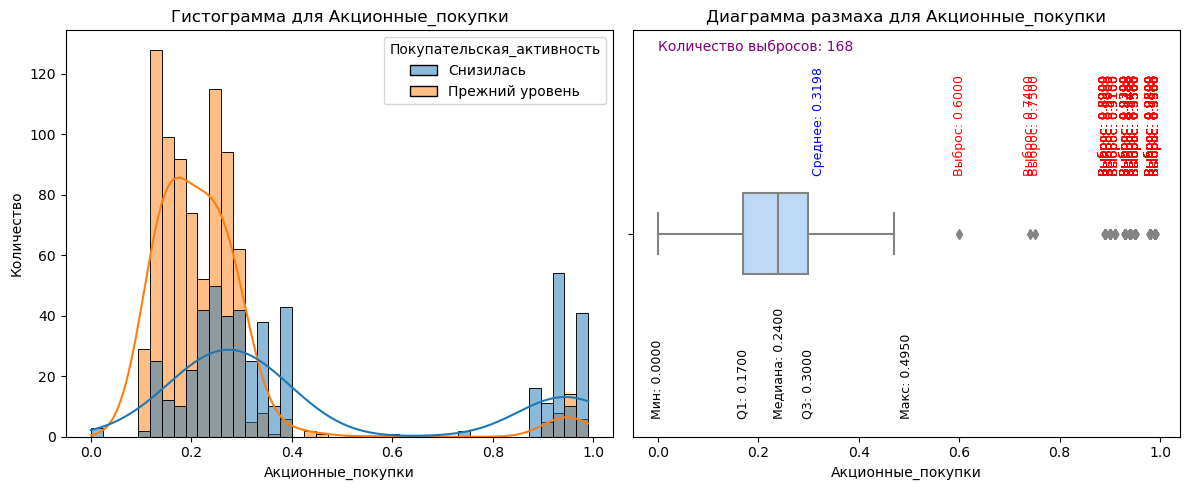

In [65]:
for feature in market_file_num_features_continuous:
    show_plots(market_file_df, feature, new_hue=market_file_df['Покупательская_активность'])

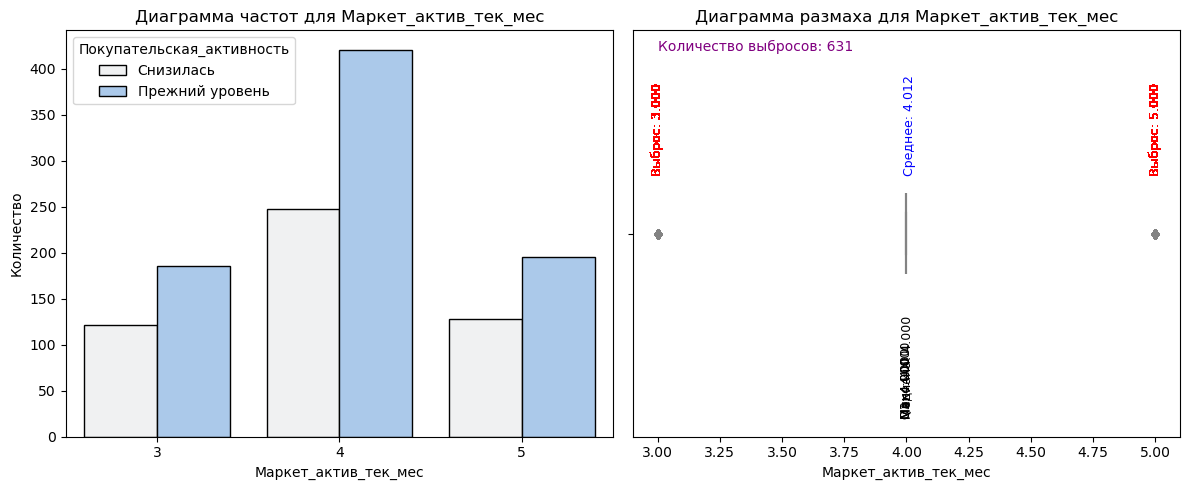

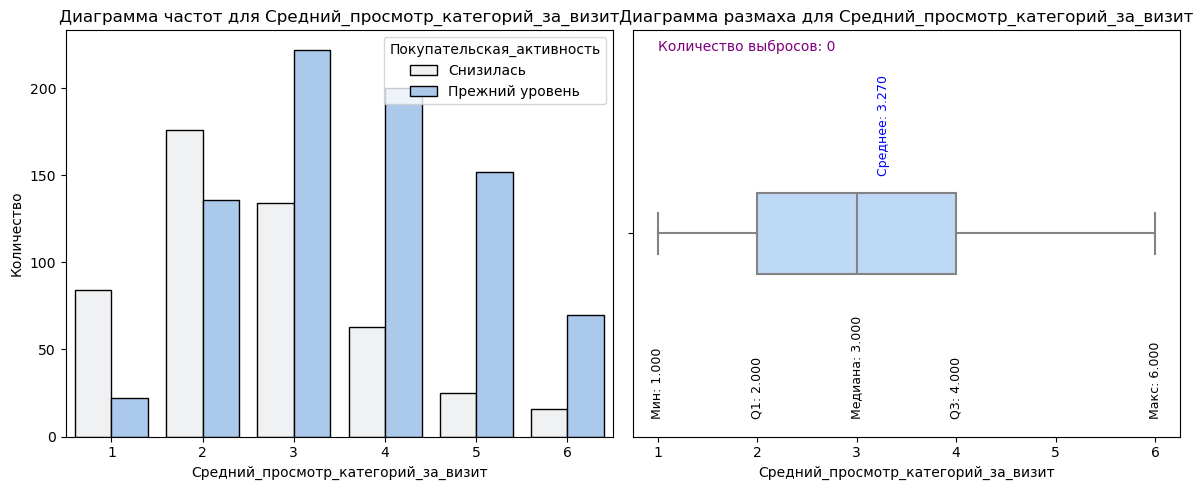

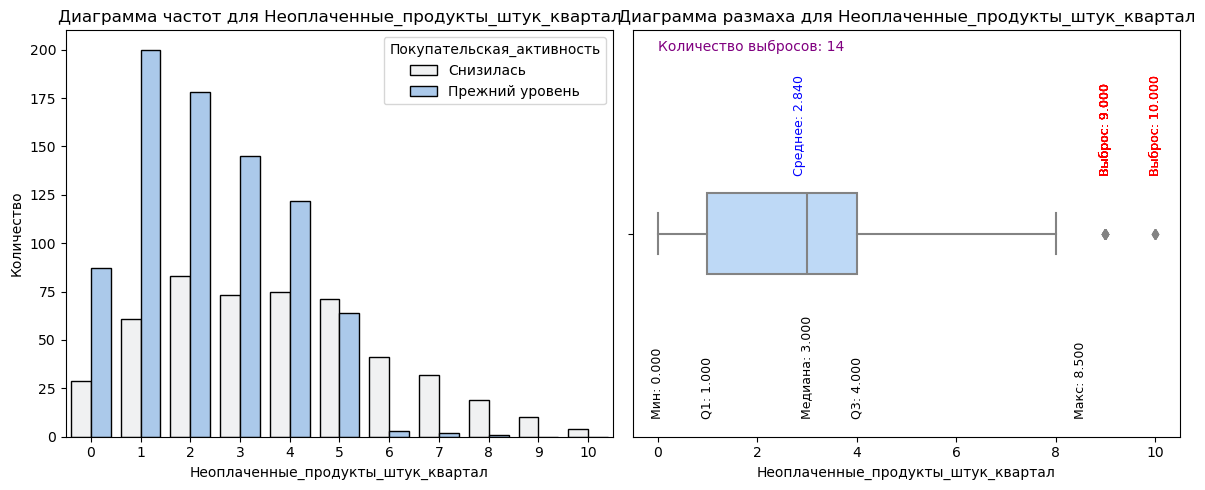

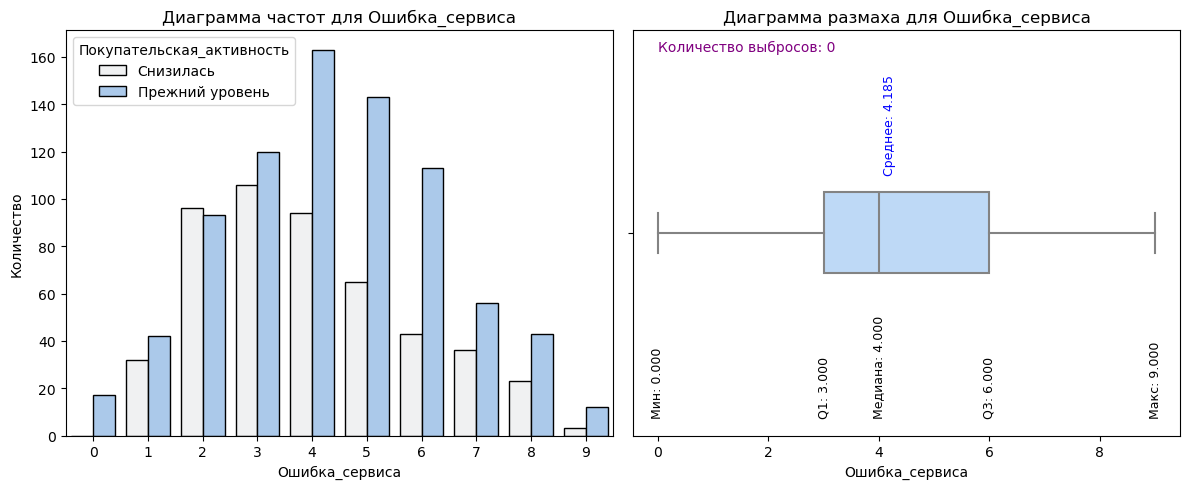

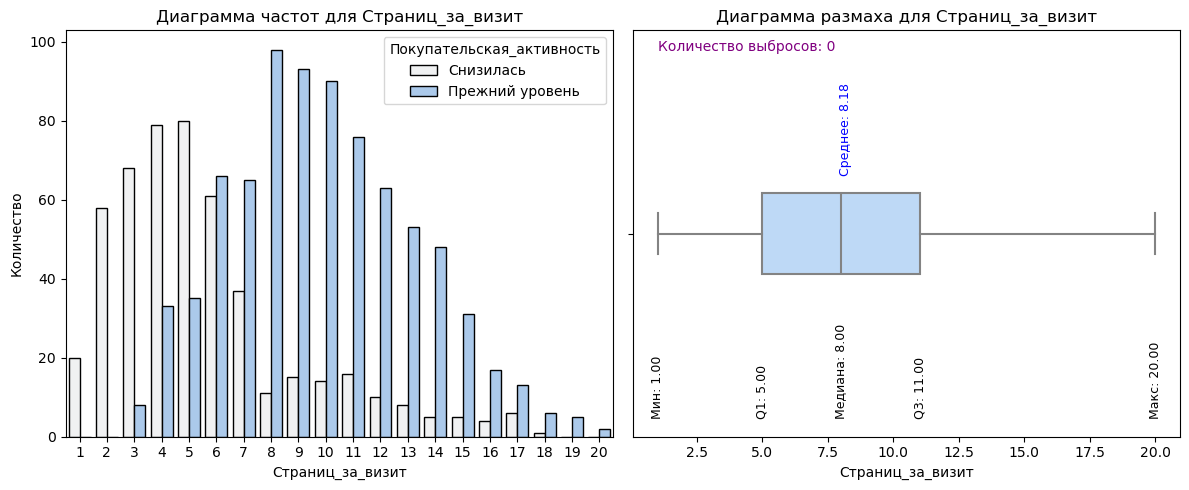

In [66]:
for feature in market_file_num_features_discrete:
    show_plots(market_file_df, feature, 'bars', new_hue=market_file_df['Покупательская_активность'])

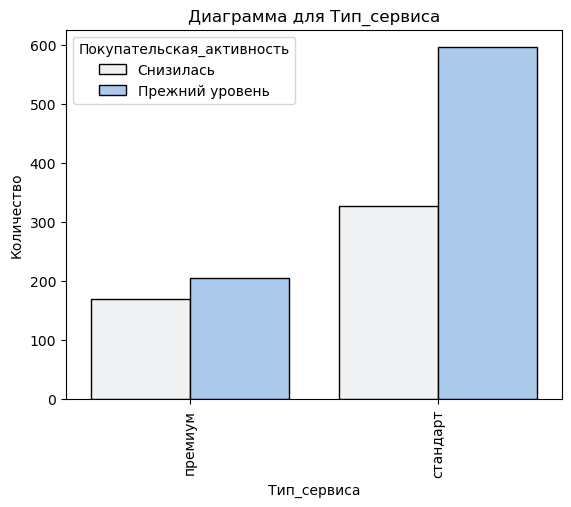

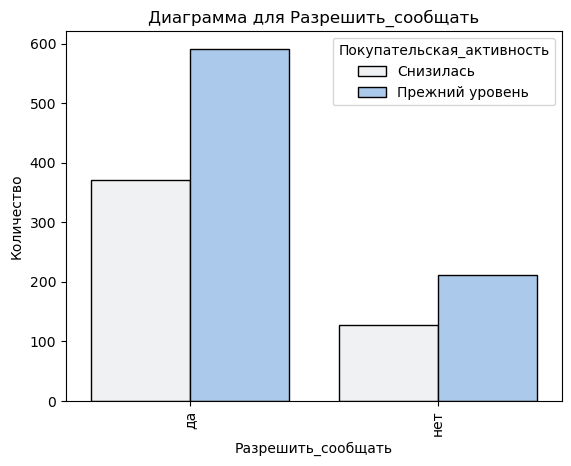

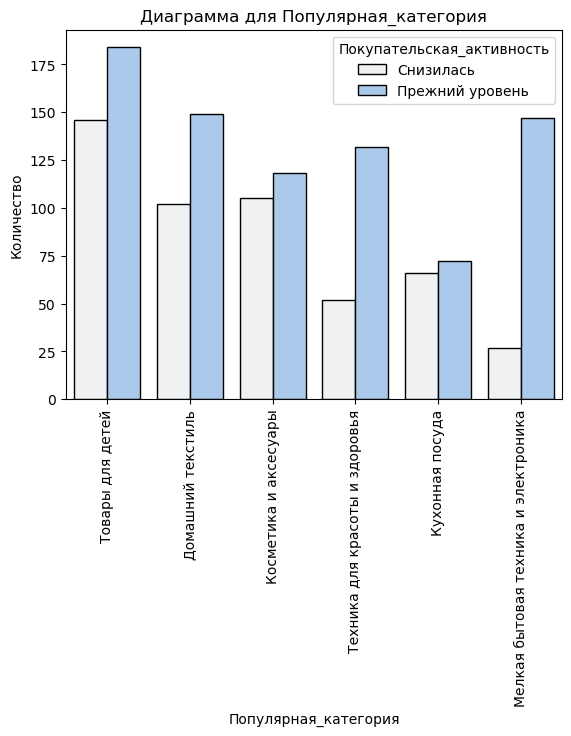

In [67]:
for feature in ['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']:
    sns.countplot(x=feature, data=market_file_df, edgecolor="black", color='#a1c9f4', hue='Покупательская_активность')
    plt.title(f'Диаграмма для {feature}')
    plt.xticks(rotation=90)
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.show()

## 4. Объединение таблиц

Объединим таблицы **market_file.csv**, **market_money.csv**, **market_time.csv**

In [68]:
market_money_df_pivot = market_money_df.pivot(index='id', columns='Период', values='Выручка').reset_index()
market_money_df_pivot.columns = ['id', 'Выручка_препредыдущий_месяц', 'Выручка_предыдущий_месяц', 'Выручка_текущий_месяц']
market_money_df_pivot 

id  Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0     215348                          0.0                       0.0   
1     215349                       5216.0                    4472.0   
2     215350                       5457.5                    4826.0   
3     215351                       6158.0                    4793.0   
4     215352                       5807.5                    4594.0   
...      ...                          ...                       ...   
1295  216643                       3664.0                    4704.0   
1296  216644                       4729.0                    5299.0   
1297  216645                       5160.0                    5334.0   
1298  216646                       4923.0                    4725.0   
1299  216647                       4720.0                    5183.0   

      Выручка_текущий_месяц  
0                    3293.1  
1                    4971.6  
2                    5058.4  
3                    6610.4  
4                    5872.5  
...                     ...  
1295                 4741.7  
1296                 5353.0  
1297                 5139.2  
1298                 5224.6  
1299                 4448.3  

[1300 rows x 4 columns]

In [69]:
market_time_df_pivot = market_time_df.pivot(index='id', columns='Период', values='Минут').reset_index()
market_time_df_pivot.columns = ['id', 'Минут_предыдущий_месяц', 'Минут_текущий_месяц']
market_time_df_pivot

id  Минут_предыдущий_месяц  Минут_текущий_месяц
0     215348                      13                   14
1     215349                      12                   10
2     215350                       8                   13
3     215351                      11                   13
4     215352                       8                   11
...      ...                     ...                  ...
1295  216643                      14                    7
1296  216644                      12                   11
1297  216645                      12                   18
1298  216646                      18                    7
1299  216647                      15                   10

[1300 rows x 3 columns]

In [70]:
market_df_merged = market_file_df.merge(market_money_df_pivot, on='id', how='left')
market_df_merged = market_df_merged.merge(market_time_df_pivot, on='id', how='left')
market_df_merged

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215348                 Снизилась     премиум                 да   
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    3.4                     5           121   
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.00                Товары для детей   
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       6                                   2   
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
0                  1                 5                          0.0   
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297               5                 7     

In [71]:
market_df_merged = market_df_merged[(market_df_merged['Выручка_препредыдущий_месяц'] != 0) & \
                                    (market_df_merged['Выручка_предыдущий_месяц'] != 0) & \
                                    (market_df_merged['Выручка_текущий_месяц'] != 0)]
market_df_merged

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
5     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
5                  1                 4                       4738.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297               5                 7     

**Промежуточный итог:**

Данные успешно объединены.

## 5. Корреляционный анализ

**5.1 Матрица корреляции**

Для удобства анализа создадим копию таблицы market_df_merged и заменим значения столбцов с категориальными данными с двумя уникальными значениями на 0 и 1.

In [72]:
market_df_merged_corr = market_df_merged.copy()

In [73]:
market_df_merged_corr['Покупательская_активность'] = market_df_merged_corr['Покупательская_активность'].map(
    {'Снизилась': 1, 'Прежний уровень': 0})
market_df_merged_corr['Тип_сервиса'] = market_df_merged_corr['Тип_сервиса'].map(
    {'премиум': 1, 'стандарт': 0})
market_df_merged_corr['Разрешить_сообщать'] = market_df_merged_corr['Разрешить_сообщать'].map(
    {'да': 1, 'нет': 0})

In [74]:
market_df_merged_corr

id  Покупательская_активность  Тип_сервиса  Разрешить_сообщать  \
1     215349                          1            1                   1   
2     215350                          1            0                   0   
3     215351                          1            0                   1   
4     215352                          1            0                   0   
5     215353                          1            0                   1   
...      ...                        ...          ...                 ...   
1295  216643                          0            0                   1   
1296  216644                          0            0                   0   
1297  216645                          0            0                   1   
1298  216646                          0            0                   1   
1299  216647                          0            1                   1   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
5                  1                 4                       4738.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297   

Выведем матрицу корреляции между признаками таблицы.

In [75]:
corr_matrix = market_df_merged_corr.drop(columns=['id', 'Популярная_категория']).corr(method='spearman')
corr_matrix

Покупательская_активность  Тип_сервиса  \
Покупательская_активность                             1.000000     0.090606   
Тип_сервиса                                           0.090606     1.000000   
Разрешить_сообщать                                    0.007223     0.188776   
Маркет_актив_6_мес                                   -0.382851    -0.082753   
Маркет_актив_тек_мес                                 -0.003501    -0.071841   
Длительность                                          0.062120     0.308212   
Акционные_покупки                                     0.470597     0.046462   
Средний_просмотр_категорий_за_визит                  -0.383179    -0.118707   
Неоплаченные_продукты_штук_квартал                    0.312088     0.055173   
Ошибка_сервиса                                       -0.113556     0.016554   
Страниц_за_визит                                     -0.548046     0.013122   
Выручка_препредыдущий_месяц                           0.049467     0.045447   
Выручка_предыдущий_месяц                             -0.368349    -0.023969   
Выручка_текущий_месяц                                 0.067785     0.019970   
Минут_предыдущий_месяц                               -0.515204    -0.100286   
Минут_текущий_месяц                                  -0.438256     0.015464   

                                     Разрешить_сообщать  Маркет_актив_6_мес  \
Покупательская_активность                      0.007223           -0.382851   
Тип_сервиса                                    0.188776           -0.082753   
Разрешить_сообщать                             1.000000           -0.010170   
Маркет_актив_6_мес                            -0.010170            1.000000   
Маркет_актив_тек_мес                           0.068193            0.061697   
Длительность                                   0.210433           -0.044614   
Акционные_покупки                             -0.010325           -0.277968   
Средний_просмотр_категорий_за_визит            0.044284            0.185027   
Неоплаченные_продукты_штук_квартал             0.096704           -0.134368   
Ошибка_сервиса                                -0.007044            0.038656   
Страниц_за_визит                               0.002611            0.319918   
Выручка_препредыдущий_месяц                   -0.000040           -0.005652   
Выручка_предыдущий_месяц                      -0.009282            0.233325   
Выручка_текущий_месяц                          0.012467            0.002680   
Минут_предыдущий_месяц                         0.012516            0.274003   
Минут_текущий_месяц                            0.027741            0.226345   

                                     Маркет_актив_тек_мес  Длительность  \
Покупательская_активность                       -0.003501      0.062120   
Тип_сервиса                                     -0.071841      0.308212   
Разрешить_сообщать                               0.068193      0.210433   
Маркет_актив_6_мес                               0.061697     -0.044614   
Маркет_актив_тек_мес                             1.000000     -0.131979   
Длительность                                    -0.131979      1.000000   
Акционные_покупки                                0.033045      0.029186   
Средний_просмотр_категорий_за_визит             -0.025158     -0.043150   
Неоплаченные_продукты_штук_квартал               0.061754     -0.108822   
Ошибка_сервиса                                   0.087351      0.103528   
Страниц_за_визит                                 0.003144     -0.034591   
Выручка_препредыдущий_месяц                     -0.027107      0.013739   
Выручка_предыдущий_месяц                        -0.039397     -0.039284   
Выручка_текущий_месяц                           -0.011758      0.014968   
Минут_предыдущий_месяц                           0.013538     -0.124000   
Минут_текущий_месяц                             -0.063044      0.083035   

                                     Акционные_покупки  \
Покупательская_

Построим тепловую карту матрицы корреляции.

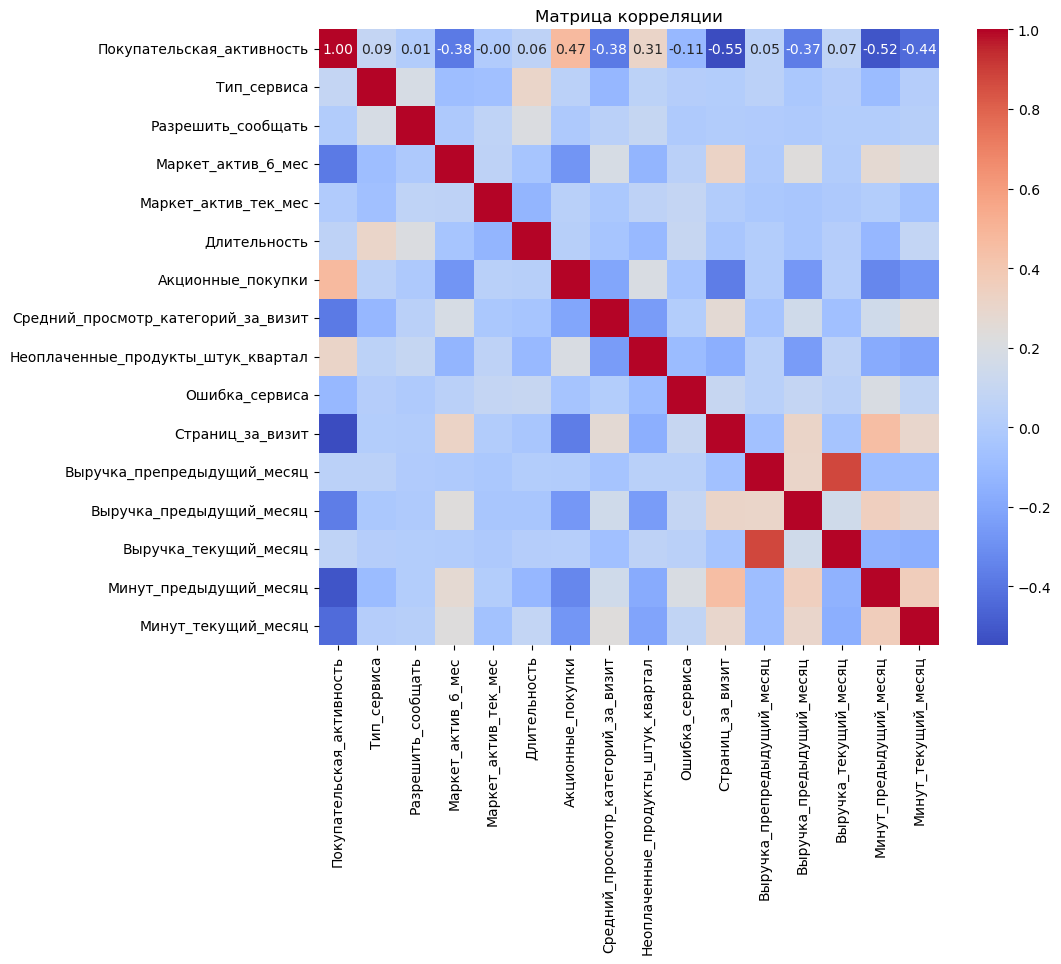

In [76]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица корреляции')
plt.show()

In [77]:
corr_list = []
for row in corr_matrix.columns:
    for col in corr_matrix.columns:
        if row < col:
            corr_value = corr_matrix.loc[row, col]
            if abs(corr_value) > 0.9:
                corr_list.append(f"1. Весьма высокая корреляция между {row} и {col}: {corr_value:.3f}")
            elif abs(corr_value) > 0.7:
                corr_list.append(f"2. Высокая корреляция между {row} и {col}: {corr_value:.3f}")
            elif abs(corr_value) > 0.5:
                corr_list.append(f"3. Заметная корреляция между {row} и {col}: {corr_value:.3f}")
            elif abs(corr_value) > 0.3:
                corr_list.append(f"4. Умеренная корреляция между {row} и {col}: {corr_value:.3f}")
            elif abs(corr_value) > 0.1:
                corr_list.append(f"5. Слабая корреляция между {row} и {col}: {corr_value:.3f}")
corr_list = sorted(corr_list)
corr_list

['2. Высокая корреляция между Выручка_препредыдущий_месяц и Выручка_текущий_месяц: 0.878',
 '3. Заметная корреляция между Минут_предыдущий_месяц и Покупательская_активность: -0.515',
 '3. Заметная корреляция между Покупательская_активность и Страниц_за_визит: -0.548',
 '4. Умеренная корреляция между Акционные_покупки и Минут_предыдущий_месяц: -0.333',
 '4. Умеренная корреляция между Акционные_покупки и Покупательская_активность: 0.471',
 '4. Умеренная корреляция между Акционные_покупки и Страниц_за_визит: -0.371',
 '4. Умеренная корреляция между Выручка_предыдущий_месяц и Выручка_препредыдущий_месяц: 0.309',
 '4. Умеренная корреляция между Выручка_предыдущий_месяц и Минут_предыдущий_месяц: 0.348',
 '4. Умеренная корреляция между Выручка_предыдущий_месяц и Покупательская_активность: -0.368',
 '4. Умеренная корреляция между Выручка_предыдущий_месяц и Страниц_за_визит: 0.311',
 '4. Умеренная корреляция между Длительность и Тип_сервиса: 0.308',
 '4. Умеренная корреляция между Маркет_актив_

**Промежуточный итог:**

Имеется высокая корреляция между Выручкой в препредыдущий месяц и Выручкой в текущий месяц.

Заметная корреляция между Покупательской активностью и Количеством страниц за посещение, а также Покупательской активностью и Временем на сайте, вероятно, является признаком мультиколлинеарности.

Учтем это при дальнейшем моделировании.

## 6. Использование пайплайнов

Построим четыре модели для прогнозирования вероятности снижения покупательской активности клиентов интернет-магазина "В один клик" в ближайшие три месяца. 

Для этого создадим пайплайн, переберем модели в пайплайне, переберем гиперпараметры моделей, оценим качество моделей и выберем лучшую.

Для оценки качества моделей будем использовать метрику ROC-AUC, которая хорошо подходит для оценки способности моделей разделять классы.

Целевой признак - Покупательская_активность. Для кодирования используем LabelEncoder.

Категориальные признаки (Тип_сервиса, Разрешить_сообщать, Популярная_категория) будем кодироать с помощью OneHotEncoder. 

Так как данные в столбцах с категориальными признаками не имеют порядка использовать OrdinalEncoder нельзя.

Количественные признаки (Маркет_актив_6_мес, Маркет_актив_тек_мес, Длительность, Акционные_покупки, Средний_просмотр_категорий_за_визит, Неоплаченные_продукты_штук_квартал, Ошибка_сервиса, Страниц_за_визит, Выручка_препредыдущий_месяц, Выручка_предыдущий_месяц, Выручка_текущий_месяц, Минут_предыдущий_месяц, Минут_текущий_месяц) будем масштабировать через StandardScaler или MinMaxScaler.

In [78]:
market_df_merged

id Покупательская_активность Тип_сервиса Разрешить_сообщать  \
1     215349                 Снизилась     премиум                 да   
2     215350                 Снизилась    стандарт                нет   
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
5     215353                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
5                  1                 4                       4738.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297               5                 7     

In [79]:
# Категориальные признаки:
ohe_columns = [
    'Тип_сервиса', 
    'Разрешить_сообщать', 
    'Популярная_категория'
]

# Количественные признаки:
num_columns = [
    'Маркет_актив_6_мес', 
    'Маркет_актив_тек_мес', 
    'Длительность', 
    'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 
    'Ошибка_сервиса', 
    'Страниц_за_визит', 
    'Выручка_препредыдущий_месяц', 
    'Выручка_предыдущий_месяц', 
    'Выручка_текущий_месяц', 
    'Минут_предыдущий_месяц', 
    'Минут_текущий_месяц'
] 

In [80]:
# Кодируем целевой признак
le = LabelEncoder()
#market_df_merged.loc[:, 'Покупательская_активность'] = le.fit_transform(market_df_merged['Покупательская_активность'])
market_df_merged['Покупательская_активность'] = le.fit_transform(market_df_merged['Покупательская_активность'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'Прежний уровень': 0, 'Снизилась': 1}


C:\Users\USER\AppData\Local\Temp\ipykernel_15596\1322934571.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_df_merged['Покупательская_активность'] = le.fit_transform(market_df_merged['Покупательская_активность'])


In [81]:
market_df_merged

id  Покупательская_активность Тип_сервиса Разрешить_сообщать  \
1     215349                          1     премиум                 да   
2     215350                          1    стандарт                нет   
3     215351                          1    стандарт                 да   
4     215352                          1    стандарт                нет   
5     215353                          1    стандарт                 да   
...      ...                        ...         ...                ...   
1295  216643                          0    стандарт                 да   
1296  216644                          0    стандарт                нет   
1297  216645                          0    стандарт                 да   
1298  216646                          0    стандарт                 да   
1299  216647                          0     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
1                  0.75                Товары для детей   
2                  0.14               Домашний текстиль   
3                  0.99                Товары для детей   
4                  0.94                Товары для детей   
5                  0.26               Домашний текстиль   
...                 ...                             ...   
1295               0.24  Техника для красоты и здоровья   
1296               0.21               Домашний текстиль   
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
5                  1                 4                       4738.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297               5           

Категория покупателей с прежним уровнем покупательской активности закодирована как 0, со снижением покупательской активности закодирована как 1.

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


drop_columns = [
    #'Тип_сервиса', 
    #'Разрешить_сообщать', 
    #'Популярная_категория',
    #'Маркет_актив_6_мес', 
    #'Маркет_актив_тек_мес', 
    #'Длительность', 
    #'Акционные_покупки', 
    #'Средний_просмотр_категорий_за_визит', 
    #'Неоплаченные_продукты_штук_квартал', 
    #'Ошибка_сервиса', 
    #'Страниц_за_визит', 
    #'Выручка_препредыдущий_месяц', 
    #'Выручка_предыдущий_месяц', 
    #'Выручка_текущий_месяц', 
    #'Минут_предыдущий_месяц', 
    #'Минут_текущий_месяц',
    'id',
    'Покупательская_активность'
]

# Делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_df_merged.drop(drop_columns, axis=1),
    market_df_merged['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_df_merged['Покупательская_активность']
)


# создаём пайплайн для подготовки признаков из списка cat_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', 
         data_preprocessor
        ),
        ('models', 
        DecisionTreeClassifier(random_state=RANDOM_STATE)
        )
    ]
)

# Создадим сетку для перебора моделей и гиперпараметров
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(3, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
        {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1
)
grid.fit(X_train, y_train)

# выведем параметры и метрикулучшей модели
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print('\nМетрика ROC-AUC для лучшей модели:', grid.best_score_)  

# Оцениваем модель на тестовом наборе
y_test_pred_proba = grid.predict_proba(X_test)[:, 1]
print(
    f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                               

**Промежуточный итог:**

В ходе выполнения данного раздела исследования были построены 4 модели, для каждой из которых был произведен подбор одного гиперпараметра.

Лучшей моделью оказалась SVC с гиперпараметром C=1. Для масштабирования количественных признаков в данной модели использовался StandardScaler().

Метрика ROC-AUC на тестовой выборке: 0.918

## 7. Анализ важности признаков

Для оценки важности признаков лучшей модели будем использовать метод SHAP.

In [83]:
# Подготовим модель и данные
best_pipeline = grid.best_estimator_
model = best_pipeline.named_steps['models']
X_train_encoded = best_pipeline['preprocessor'].transform(X_train)
X_test_encoded = best_pipeline['preprocessor'].transform(X_test)

In [84]:
explainer = shap.PermutationExplainer(model.predict_proba, X_train_encoded)

In [85]:
shap_values = explainer(X_test_encoded)

PermutationExplainer explainer: 326it [05:03,  1.05it/s]                                                               


In [86]:
labels = best_pipeline['preprocessor'].get_feature_names_out()

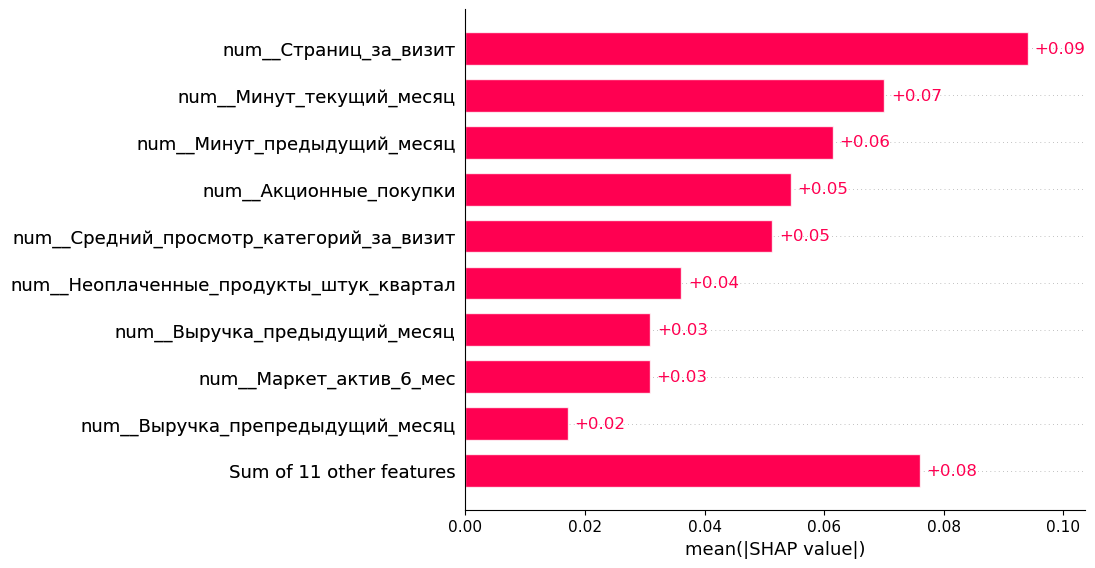

In [87]:
shap_values_fixed = shap.Explanation(
    values=shap_values.values[..., 1],  # Берём SHAP-значения для класса 1
    base_values=shap_values.base_values[..., 1],  
    data=X_test_encoded,  
    feature_names=labels  
)

shap.plots.bar(shap_values_fixed)

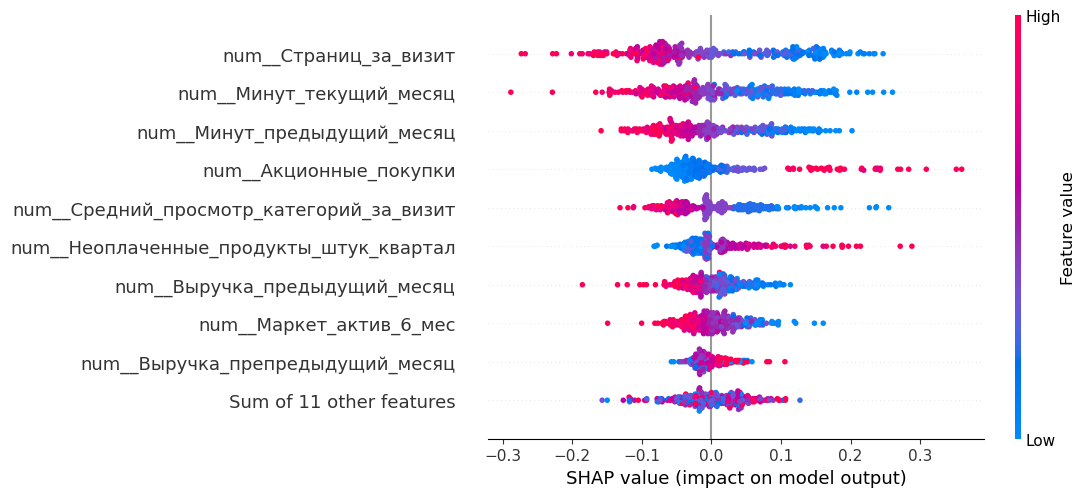

In [88]:
shap.plots.beeswarm(shap_values_fixed) 

**Промежуточный итог:**

Категория покупателей с прежним уровнем покупательской активности закодирована как 0, со снижением покупательской активности закодирована как 1.

Наибольшее влияние на результаты прогнозирования снижения покупательской активности оказывает признак Страниц_за_визит. Также высокое влияние на результаты моделирования оказывают признаки Минут_текущий_месяц и Минут_предыдущий_месяц. Маленькие значения данных признаков склоняют модель отнести покупателя к категории со сниженной покупательской активностью.

Также стоит отметить высокое влияние признака Акционные покупки. Низкое количество акционных покупок склоняет модель отнести покупателя к категории с неизменной покупательской активностью.

## 8. Сегментация покупателей

Введем в таблицу данные о предсказанной вероятности снижения покупательской активности и прибыли клиентов.

In [89]:
market_df_merged = market_df_merged.merge(money_df, on='id', how='left')

In [90]:
y_pred_proba = grid.predict_proba(market_df_merged.drop(drop_columns, axis=1))[:, 1]
y_pred_proba

array([0.98525674, 0.45562812, 0.87342352, ..., 0.03748698, 0.10286313,
       0.36996119])

In [91]:
market_df_merged['Вероятность_снижения_покупательской_активности'] = y_pred_proba
market_df_merged

id  Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215349                          1     премиум                 да   
1     215350                          1    стандарт                нет   
2     215351                          1    стандарт                 да   
3     215352                          1    стандарт                нет   
4     215353                          1    стандарт                 да   
...      ...                        ...         ...                ...   
1292  216643                          0    стандарт                 да   
1293  216644                          0    стандарт                нет   
1294  216645                          0    стандарт                 да   
1295  216646                          0    стандарт                 да   
1296  216647                          0     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    4.4                     4           819   
1                    4.9                     3           539   
2                    3.2                     5           896   
3                    5.1                     3          1064   
4                    3.3                     4           762   
...                  ...                   ...           ...   
1292                 6.6                     3           318   
1293                 5.1                     4           454   
1294                 4.1                     3           586   
1295                 6.3                     5           645   
1296                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.75                Товары для детей   
1                  0.14               Домашний текстиль   
2                  0.99                Товары для детей   
3                  0.94                Товары для детей   
4                  0.26               Домашний текстиль   
...                 ...                             ...   
1292               0.24  Техника для красоты и здоровья   
1293               0.21               Домашний текстиль   
1294               0.20               Домашний текстиль   
1295               0.12  Техника для красоты и здоровья   
1296               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
0                                       4                                   4   
1                                       5                                   2   
2                                       5                                   0   
3                                       3                                   2   
4                                       4                                   1   
...                                   ...                                 ...   
1292                                    5                                   3   
1293                                    6                                   2   
1294                                    3                                   2   
1295                                    3                                   3   
1296                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  Выручка_препредыдущий_месяц  \
0                  2                 5                       5216.0   
1                  1                 5                       5457.5   
2                  6                 4                       6158.0   
3                  3                 2                       5807.5   
4                  1                 4                       4738.5   
...              ...               ...                          ...   
1292               3                11                       3664.0   
1293               3                 9                       4729.0   
1294               5           

Посмотрим внимательнее на зависимость вероятности снижения покупательской активности от количества акционных покупок.

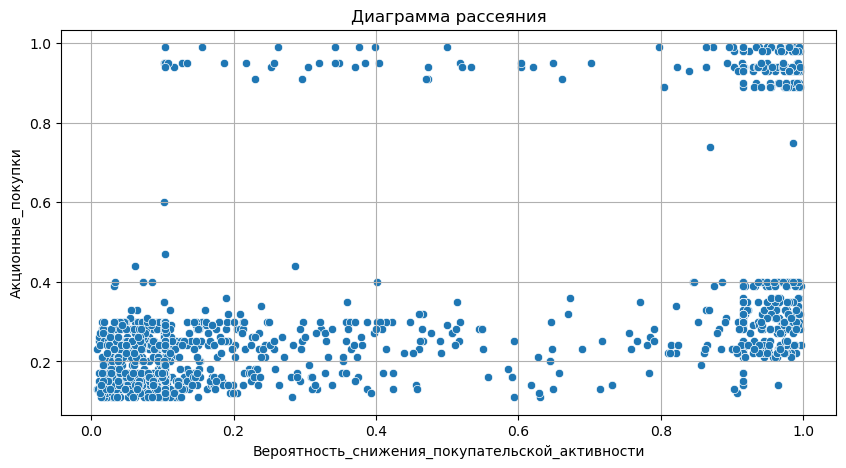

In [92]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=market_df_merged['Вероятность_снижения_покупательской_активности'], y=market_df_merged['Акционные_покупки'])
plt.title('Диаграмма рассеяния')
plt.xlabel('Вероятность_снижения_покупательской_активности')
plt.ylabel('Акционные_покупки')
plt.grid(True)
plt.show()

Покупатели с большой долей акционных покупок более склонны к снижению покупательской активности.

Проведем кластеризацию клиентов по признаку Акционные_покупки и добавим категорию Акционные_покупатели в таблицу.

In [93]:
market_df_merged['Акционный_покупатель'] = market_df_merged['Акционные_покупки'].apply(lambda x: 'да' if x > 0.5 else 'нет')
market_df_merged

id  Покупательская_активность Тип_сервиса Разрешить_сообщать  \
0     215349                          1     премиум                 да   
1     215350                          1    стандарт                нет   
2     215351                          1    стандарт                 да   
3     215352                          1    стандарт                нет   
4     215353                          1    стандарт                 да   
...      ...                        ...         ...                ...   
1292  216643                          0    стандарт                 да   
1293  216644                          0    стандарт                нет   
1294  216645                          0    стандарт                 да   
1295  216646                          0    стандарт                 да   
1296  216647                          0     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
0                    4.4                     4           819   
1                    4.9                     3           539   
2                    3.2                     5           896   
3                    5.1                     3          1064   
4                    3.3                     4           762   
...                  ...                   ...           ...   
1292                 6.6                     3           318   
1293                 5.1                     4           454   
1294                 4.1                     3           586   
1295                 6.3                     5           645   
1296                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
0                  0.75                Товары для детей   
1                  0.14               Домашний текстиль   
2                  0.99                Товары для детей   
3                  0.94                Товары для детей   
4                  0.26               Домашний текстиль   
...                 ...                             ...   
1292               0.24  Техника для красоты и здоровья   
1293               0.21               Домашний текстиль   
1294               0.20               Домашний текстиль   
1295               0.12  Техника для красоты и здоровья   
1296               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  ...  Ошибка_сервиса  \
0                                       4  ...               2   
1                                       5  ...               1   
2                                       5  ...               6   
3                                       3  ...               3   
4                                       4  ...               1   
...                                   ...  ...             ...   
1292                                    5  ...               3   
1293                                    6  ...               3   
1294                                    3  ...               5   
1295                                    3  ...               5   
1296                                    4  ...               3   

      Страниц_за_визит  Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
0                    5                       5216.0                    4472.0   
1                    5                       5457.5                    4826.0   
2                    4                       6158.0                    4793.0   
3                    2                       5807.5                    4594.0   
4                    4                       4738.5                    5124.0   
...                ...                          ...                       ...   
1292                11                       3664.0                    4704.0   
1293                 9                       4729.0                    5299.0   
1294                 7                       5160.0                    5334.0   
1295                 7                  

Посмотрим статистическую информацию для двух категорий покупателей: в высокой долей акционных покупок и с низкой.

In [94]:
market_df_merged[market_df_merged['Акционный_покупатель'] == 'да'].describe()

id  Покупательская_активность  Маркет_актив_6_мес  \
count     168.000000                 168.000000          168.000000   
mean   215753.154762                   0.797619            3.770238   
std       382.942562                   0.402976            1.084102   
min    215349.000000                   0.000000            0.900000   
25%    215480.750000                   1.000000            3.275000   
50%    215625.500000                   1.000000            4.000000   
75%    215842.500000                   1.000000            4.400000   
max    216647.000000                   1.000000            5.700000   

       Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
count             168.00000    168.000000         168.000000   
mean                3.97619    602.964286           0.940655   
std                 0.70032    239.714273           0.046444   
min                 3.00000    147.000000           0.600000   
25%                 3.00000    435.250000           0.930000   
50%                 4.00000    613.000000           0.940000   
75%                 4.00000    800.250000           0.980000   
max                 5.00000   1064.000000           0.990000   

       Средний_просмотр_категорий_за_визит  \
count                           168.000000   
mean                              2.815476   
std                               1.293187   
min                               1.000000   
25%                               2.000000   
50%                               3.000000   
75%                               4.000000   
max                               6.000000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
count                          168.000000      168.000000        168.000000   
mean                             3.613095        4.130952          5.732143   
std                              2.483299        1.823202          3.260126   
min                              0.000000        0.000000          1.000000   
25%                              2.000000        3.000000          3.000000   
50%                              3.000000        4.000000          5.000000   
75%                              5.000000        5.000000          7.000000   
max                             10.000000        8.000000         15.000000   

       Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
count                   168.000000                 168.00000   
mean                   4940.547619                4712.47619   
std                     781.881039                 289.80741   
min                    3061.000000                4098.00000   
25%                    4447.125000                4491.00000   
50%                    5070.750000                4698.00000   
75%                    5516.500000                4876.25000   
max                    6716.500000                5612.00000   

       Выручка_текущий_месяц  Минут_предыдущий_месяц  Минут_текущий_месяц  \
count             168.000000              168.000000           168.000000   
mean             5247.114286               11.398810            11.428571   
std               843.095332                3.564865             3.653513   
min              3232.200000                5.000000             4.000000   
25%              4697.150000                9.000000             9.000000   
50%              5203.850000               11.000000            11.000000   
75%              5775.450000               14.000000            13.000000   
max              7799.400000               23.000000            22.000000   

           Прибыль  Вероятность_снижения_покупательской_активности  
count   168.000000                                      168.000000  
mean   3868.571429                                        0.808543  
std    1003.238639                                        0.277423  
min    1330.000000                                        0.102778  
25%    3162.500000                                        

In [95]:
market_df_merged[market_df_merged['Акционный_покупатель'] == 'нет'].describe()

id  Покупательская_активность  Маркет_актив_6_мес  \
count    1129.000000                1129.000000         1129.000000   
mean   216035.567759                   0.319752            4.326484   
std       359.381942                   0.466587            0.985389   
min    215350.000000                   0.000000            0.900000   
25%    215752.000000                   0.000000            3.800000   
50%    216050.000000                   0.000000            4.300000   
75%    216333.000000                   1.000000            5.000000   
max    216646.000000                   1.000000            6.600000   

       Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
count           1129.000000   1129.000000        1129.000000   
mean               4.014172    602.998229           0.228273   
std                0.695587    250.571121           0.074158   
min                3.000000    121.000000           0.110000   
25%                4.000000    403.000000           0.160000   
50%                4.000000    606.000000           0.230000   
75%                4.000000    808.000000           0.280000   
max                5.000000   1079.000000           0.470000   

       Средний_просмотр_категорий_за_визит  \
count                          1129.000000   
mean                              3.334810   
std                               1.351202   
min                               1.000000   
25%                               2.000000   
50%                               3.000000   
75%                               4.000000   
max                               6.000000   

       Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
count                         1129.000000     1129.000000       1129.000000   
mean                             2.726306        4.192205          8.551816   
std                              1.860000        1.969918          3.945688   
min                              0.000000        0.000000          1.000000   
25%                              1.000000        3.000000          5.000000   
50%                              2.000000        4.000000          8.000000   
75%                              4.000000        6.000000         11.000000   
max                             10.000000        9.000000         20.000000   

       Выручка_препредыдущий_месяц  Выручка_предыдущий_месяц  \
count                  1129.000000               1129.000000   
mean                   4949.499114               4854.803366   
std                     688.794505                335.677927   
min                    2890.000000               4102.000000   
25%                    4515.000000               4604.000000   
50%                    5004.500000               4833.000000   
75%                    5398.000000               5090.000000   
max                    6869.500000               5663.000000   

       Выручка_текущий_месяц  Минут_предыдущий_месяц  Минут_текущий_месяц  \
count            1129.000000             1129.000000          1129.000000   
mean             5236.505580               13.777679            13.476528   
std               833.044589                3.897080             4.235910   
min              2758.700000                5.000000             4.000000   
25%              4711.200000               11.000000            10.000000   
50%              5179.400000               14.000000            13.000000   
75%              5750.400000               17.000000            17.000000   
max              7605.300000               23.000000            23.000000   

           Прибыль  Вероятность_снижения_покупательской_активности  
count  1129.000000                                     1129.000000  
mean   4016.811337                                        0.323258  
std    1010.969323                                        0.363385  
min     860.000000                                        0.007496  
25%    3320.000000                                        

Построим диаграммы рассеяния для Вероятность_снижения_покупательской_активности и всех количественных признаков с учетом категории Акционный_покупатель

In [96]:
def plot_scatter(num_feature):
    sns.scatterplot(
        x='Вероятность_снижения_покупательской_активности', 
        y=num_feature, 
        hue='Акционный_покупатель',
        data=market_df_merged)
    plt.title('Диаграмма рассеяния. Вероятность_снижения_покупательской_активности и ' + num_feature)
    plt.xlabel('Вероятность_снижения_покупательской_активности')
    plt.ylabel(num_feature)
    plt.grid(True)
    plt.show()

In [97]:
num_columns = [
    'Маркет_актив_6_мес', 
    'Маркет_актив_тек_мес', 
    'Длительность', 
    'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит', 
    'Неоплаченные_продукты_штук_квартал', 
    'Ошибка_сервиса', 
    'Страниц_за_визит', 
    'Выручка_препредыдущий_месяц', 
    'Выручка_предыдущий_месяц', 
    'Выручка_текущий_месяц', 
    'Минут_предыдущий_месяц', 
    'Минут_текущий_месяц',
    'Прибыль'
]

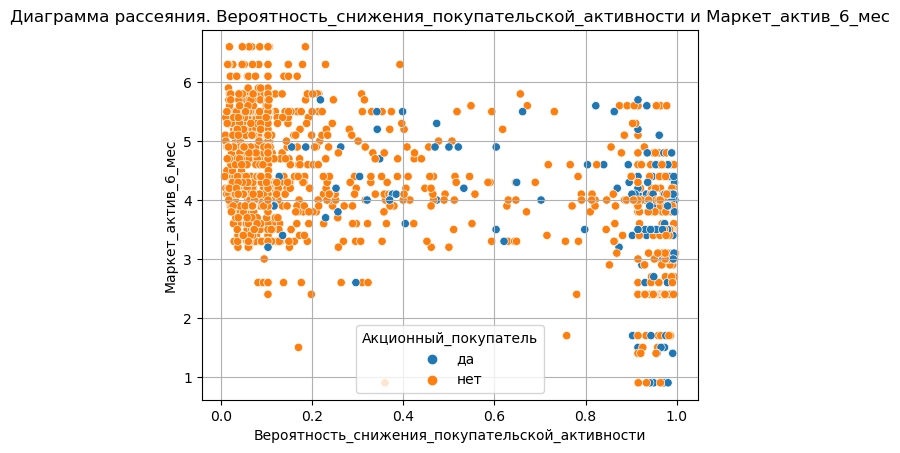

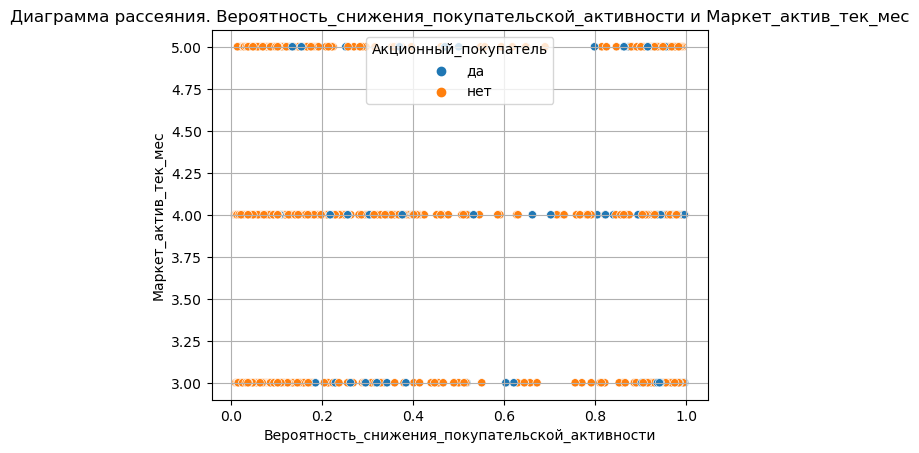

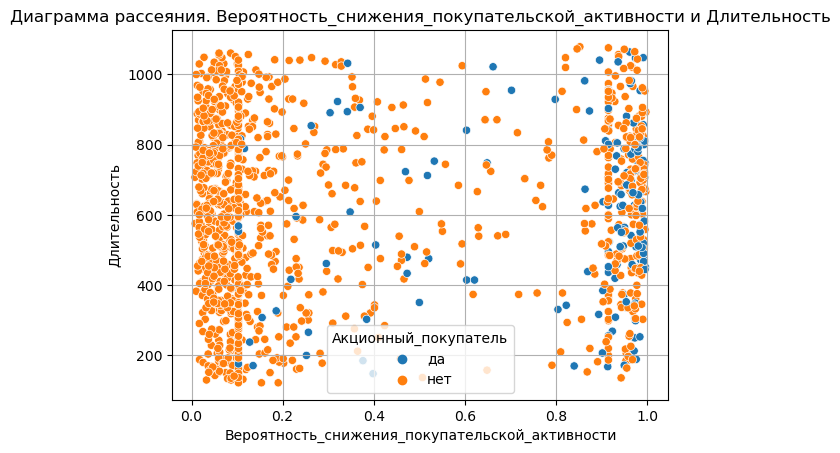

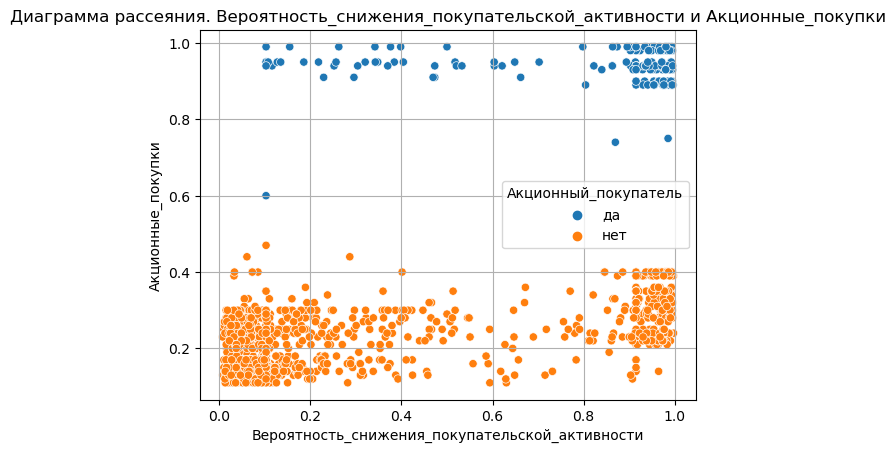

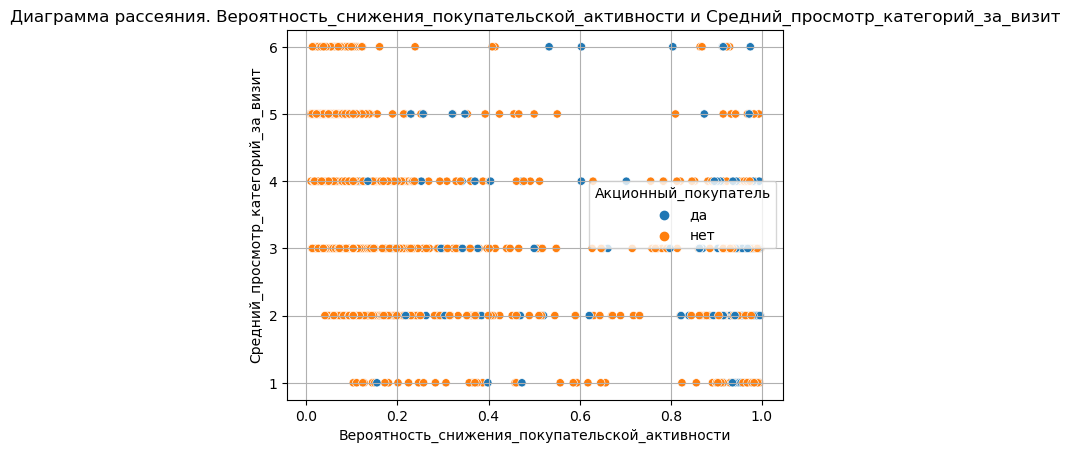

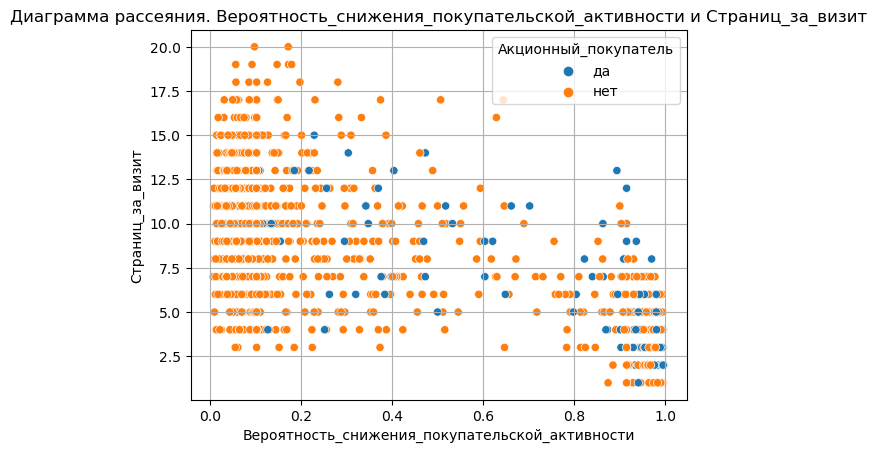

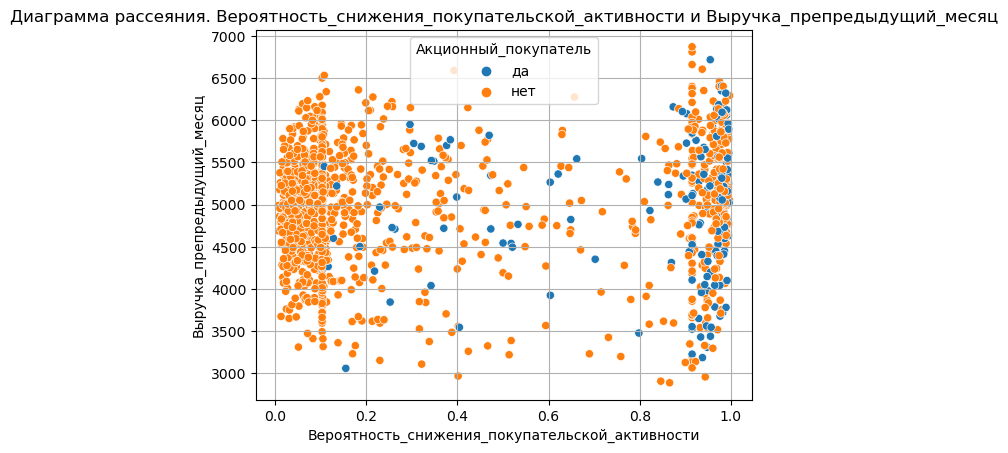

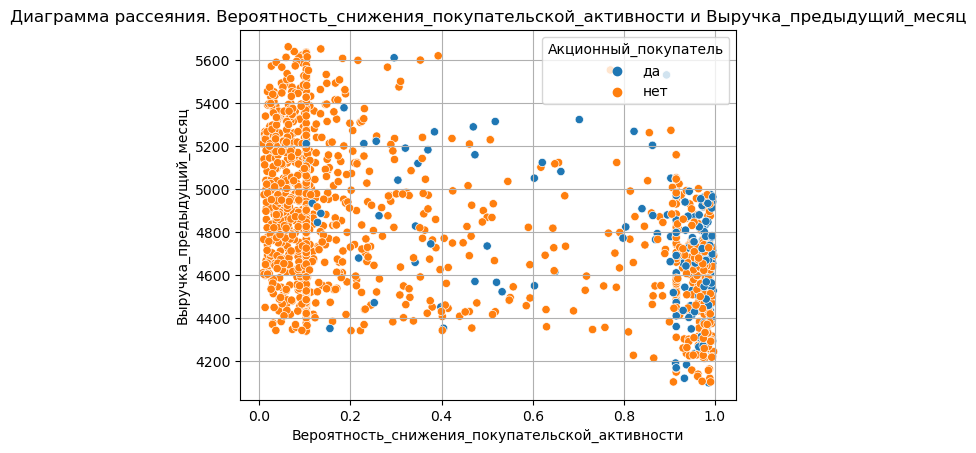

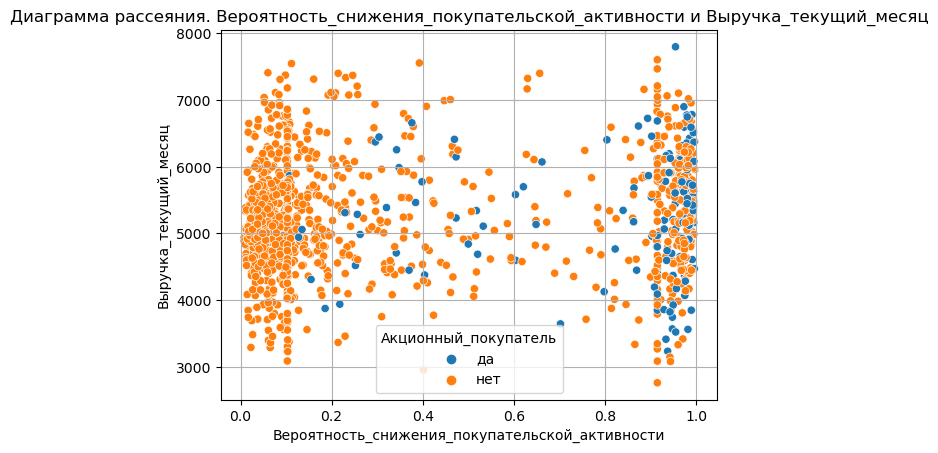

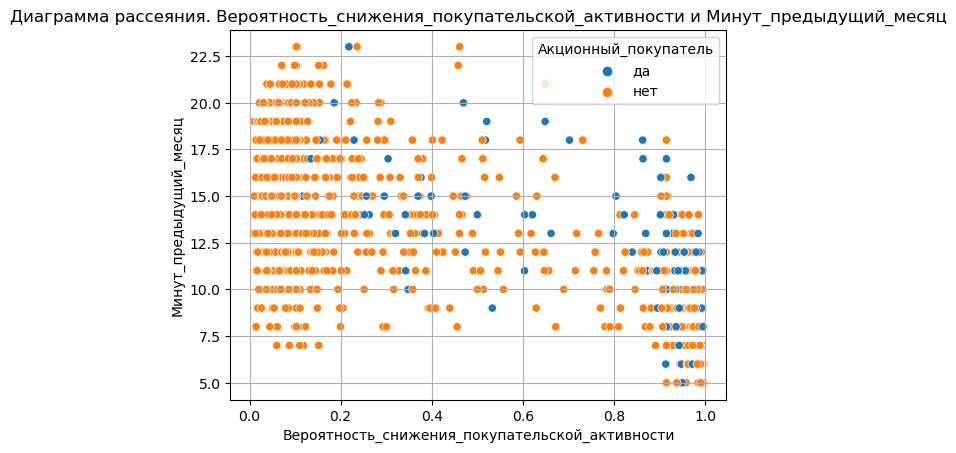

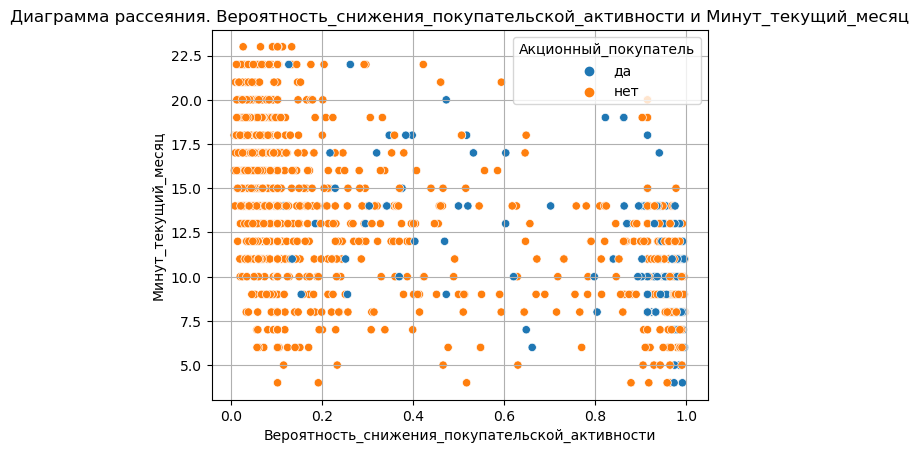

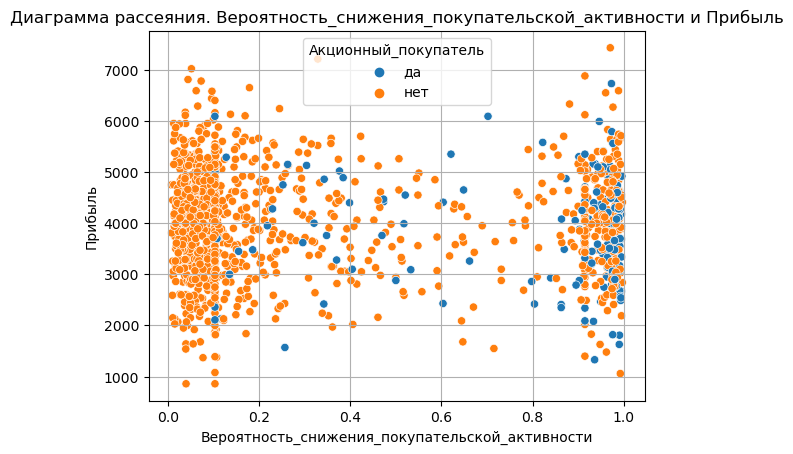

In [98]:
for x in num_columns:
    plot_scatter(x)

**Промежуточный итог:**

Была проведена кластеризация клиентов по признаку Акционные_покупки. Был введен новый признак 'Акционный_покупатель' со значением 'да' для покупателей с высокой долей акционных покупок и 'нет' для покупателей с низкой долей акционных покупок.

Акционные покупатели имеют большую вероятность снижения покупательской активности.

Выручка у акционных покупателей и обычных приблизительно одинаковая. При этом Акционные покупатели в среднем приносят меньшую прибыль.

Акционные покупатели меньше времени проводят на сайте, посещают меньше страниц и просматривают меньше категорий.

Акционные покупатели имеют больше неоплаченных покупок в корзине.

Количество ошибок сервиса не коррелирует со снижением покупательской активности.

Маркетинговая активность за текущий месяц одинаковая у обеих категорий покупателей.

**Предложения:**

1. Для увеличения вовлеченности акционных покупателей:
   * Персонализированные рекомендации: улучшение рекомендаций товаров на основе прошлых покупок и интересов поможет стимулировать большее исследование других категорий.
   * Геймификация покупок: Введение элементов игры (например, накопление баллов, достижение новых уровней) в процесс покупок для создания ощущения вовлеченности.
   * Создание платных подписок, в рамках которых покупатели получают дополнительные скидки.
2. Для стимулирования совершения покупок:
   * Создание **ограниченных по времени предложений** с персональными скидками или акциями для акционных покупателей может мотивировать их завершать покупки, а не оставлять товары в корзине.
   * Разработка **динамичных скидок**: например, если покупатель оставляет товар в корзине, предложить ему дополнительную скидку или бонус для завершения покупки.

## Общий вывод

**Целью проекта** было построение модели машинного обучения для прогнозирования вероятности снижения покупательской активности клиентов интернет-магазина «В один клик» в ближайшие три месяца, с целью улучшения персонализированных предложений и увеличения лояльности клиентов.

**Задачи**, которые были решены:
* Загружены и объединены данные из четырёх таблиц, содержащих информацию о поведении покупателей, выручке, времени на сайте и прибыли от покупок.
* Проведена предобработка данных.
* Проведен исследовательский анализ данных.
* Создан пайплайн. Произведен перебор четырех моделей, перебор гиперпараметров моделей, перебор способов масштабирования количественных признаков.
* Проведена кластеризация клиентов с использованием признака «акционные покупки», что позволило выделить группу клиентов с высокой вероятностью снижения покупательской активности.

**Ключевые выводы**:
* Наилучшее качество прогнозирования снижения покупательской активности показала модель SVC с гиперпараметром C=1. Метрика ROC-AUC на тестовой выборке: 0.907.
* Наибольшее влияние на прогнозирование снижения покупательской активности оказывют признак «Страниц_за_визит», а также показатели «Минут_текущий_месяц» и «Минут_предыдущий_месяц».
* Имеется высокая корреляция между снижением вовлеченности покупателей в процесс взаимодействия с интернет-магазином «В один клик» и снижения покупательской активности.
* Покупатели с большой долей акционных покупок более склонны к снижению покупательской активности.

**Предложения:**
 1. Увеличение вовлеченности акционных покупателей.
 2. Стимулирование совершения покупок.
 3. Провести исследонание влияния количества маркетинговых коммуникаций на покупательскую активность. Для группы покупателей увеличить маркетинговые коммуникации с напоминаними о товарах в корзине и персональными предложениями, и сравнить показатели покупательской активности с показателями контрольной группы.